In [622]:
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, GRU, Flatten, concatenate, Input, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime, calendar
import numpy as np
import pandas as pd
import os
import joblib
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,median_absolute_error


In [623]:
from functions import r_square, complete_localization, generate_data, generate_df_date, localization
# SELECCIONAR AÑO INICIAL Y FINAL
year_ini = 2012
year_end = 2013
# HORAS NECESARIAS (ENTRADA)
n_hours_b = 24

# HORAS FUTURAS A PREDECIR (SALIDA)
n_hours_f = 1

# INGRSAR EL NOMBRE DE LA ESTACIÓN QUE SERÁ DE TEST, ES DECIR
# EN EL TRAINING SE QUITARÁ LA ESTACIÓN INGRESADA, EN ESTE CASO, INDEPENDENCIA
test_station = 'ElBosque'

# # COLUMNAS A ELIMINAR (ENTRADA Y SALIDA)
_drop_column = ['Estacion', 'numero_semana']

# VARIABLES DE ENTRADA
input_columns = ['hrel', 'no2', 'temp', 'velv', 'pm25','pm10','hora']

# VARIABLES DE SALIDA
# output_columns = ['hrel', 'no2', 'temp', 'velv', 'pm25']
output_columns = ['pm25']
# COLUMNAS ESTÁTICAS
_static_columns = ['E', 'N']

In [624]:
%load_ext autoreload
%autoreload 2

columns = ['pm25', 'no2', 'hrel', 'temp', 'velv', 'pm10','hora']
df, _df = generate_df_date(year_ini, year_end, columns, './data/data_completa11/')

# # COLUMNAS DE ENTRADA (NO SE DEBEN REPETIR EN LAS COLUMNAS A ELIMINAR)
_drop_b = list(set(df.columns.values) - set(input_columns) - set(_static_columns) - set(_drop_column))

# # COLUMNAS DE SALIDA (NO SE DEBEN REPETIR EN LAS COLUMNAS A ELIMINAR)
_drop_f = list(set(df.columns.values) - set(output_columns) - set(_static_columns) - set(_drop_column))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['Talagante.csv', 'Quilicura.csv', 'PuenteAlto.csv', 'Pudahuel.csv', 'ParqueOhiggins.csv', 'LasCondes.csv', 'LaFlorida.csv', 'Independencia.csv', 'ElBosque.csv', 'CerroNavia.csv', 'Cerrillos.csv']
GENERANDO LAS LISTAS DE FECHAS


  0%|          | 0/17544 [00:00<?, ?it/s]

In [625]:
print(df.head())
print(df.shape)

        Estacion         E          N    anho  mes  dia  hora  numero_semana  \
17520  Talagante  318945.0  6272298.0  2012.0  1.0  1.0   0.0           52.0   
17521  Talagante  318945.0  6272298.0  2012.0  1.0  1.0   1.0           52.0   
17522  Talagante  318945.0  6272298.0  2012.0  1.0  1.0   2.0           52.0   
17523  Talagante  318945.0  6272298.0  2012.0  1.0  1.0   3.0           52.0   
17524  Talagante  318945.0  6272298.0  2012.0  1.0  1.0   4.0           52.0   

       numero_dia  tipo_dia  estacion_anho  pm25  pm10      no2     temp  \
17520         6.0       0.0            1.0  22.0   6.0  4.86955  14.0833   
17521         6.0       0.0            1.0  18.0   1.0  3.72825  13.3917   
17522         6.0       0.0            1.0  19.0   3.5  3.78260  12.8000   
17523         6.0       0.0            1.0  19.5  10.5  3.45651  12.1250   
17524         6.0       0.0            1.0  20.0  22.0  3.80977  11.9250   

           velv     hrel  
17520  0.173551  83.0833  
17521  0

In [626]:
# df_train, df_test,date_row_train,date_df_test = generate_data(year_ini, year_end, n_hours_b, n_hours_f, _static_columns, _drop_column, _drop_b, _drop_f, df, _df)
df_train, df_test = generate_data(year_ini, year_end, n_hours_b, n_hours_f, _static_columns, _drop_column, _drop_b, _drop_f, df, _df)
del df, _df

/Users/mark1/miniforge3/envs/tensorflow/lib/python3.8/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/mark1/miniforge3/envs/tensorflow/lib/python3.8/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


GENERANDO ENTRENAMIENTO


  0%|          | 0/8760 [00:00<?, ?it/s]

GENERANDO TEST


  0%|          | 0/8736 [00:00<?, ?it/s]

In [627]:
print(list(df_train.columns))

['E (Talagante)', 'N (Talagante)', 'hora (Talagante)(t-23)', 'pm25 (Talagante)(t-23)', 'pm10 (Talagante)(t-23)', 'no2 (Talagante)(t-23)', 'temp (Talagante)(t-23)', 'velv (Talagante)(t-23)', 'hrel (Talagante)(t-23)', 'hora (Talagante)(t-22)', 'pm25 (Talagante)(t-22)', 'pm10 (Talagante)(t-22)', 'no2 (Talagante)(t-22)', 'temp (Talagante)(t-22)', 'velv (Talagante)(t-22)', 'hrel (Talagante)(t-22)', 'hora (Talagante)(t-21)', 'pm25 (Talagante)(t-21)', 'pm10 (Talagante)(t-21)', 'no2 (Talagante)(t-21)', 'temp (Talagante)(t-21)', 'velv (Talagante)(t-21)', 'hrel (Talagante)(t-21)', 'hora (Talagante)(t-20)', 'pm25 (Talagante)(t-20)', 'pm10 (Talagante)(t-20)', 'no2 (Talagante)(t-20)', 'temp (Talagante)(t-20)', 'velv (Talagante)(t-20)', 'hrel (Talagante)(t-20)', 'hora (Talagante)(t-19)', 'pm25 (Talagante)(t-19)', 'pm10 (Talagante)(t-19)', 'no2 (Talagante)(t-19)', 'temp (Talagante)(t-19)', 'velv (Talagante)(t-19)', 'hrel (Talagante)(t-19)', 'hora (Talagante)(t-18)', 'pm25 (Talagante)(t-18)', 'pm10 (T

In [628]:
# print(df_train.shape)
# print(date_row_train.shape)
# print(df_test.shape)
# print(date_df_test.shape)
# date_df_train=date_row_train
# print(date_df_test.head())

In [629]:
print(list(df_train.iloc[0:200,2]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0,

In [630]:
# CAMBIAMOS DE TIPO DE DATO LOS VALORES A FLOTANTES
df_train = df_train[df_train.columns.values].astype(np.float)
df_test = df_test[df_test.columns.values].astype(np.float)

/var/folders/h9/jj1853p962b96ly1x0_pg5jm0000gq/T/ipykernel_99187/895944274.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_train = df_train[df_train.columns.values].astype(np.float)
/var/folders/h9/jj1853p962b96ly1x0_pg5jm0000gq/T/ipykernel_99187/895944274.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_test = df_test[df_tes

In [631]:
# NO MODIFICAR, ES EL ORDEN DE LAS COLUMNAS Y CORDEANDAS
E = []
N = []
stations_name = []

for _station_name in df_train.columns:
    if 'E (' in _station_name:
        stations_name.append(_station_name.replace('E (', '').replace(')', ''))

total_station = len(stations_name)

# INSERTO LAS CORDENADAS DE LA ESTACIÓN QUE TINE LOS VALORES -1
# ES DECIR SI CERRILLOS TIENE EL VALOR -1 E' Y N' SON LAS CORDEANDAS DE CERRILLOS
# EL ORDEN LO DESIGNA LAS COLUMNAS, EN ESTE CASO, INICIAMOS CON CERRILLOS, CERRONAVIA.... 
#for station in ["Cerrillos", "CerroNavia", "ElBosque", "Independencia", "LaFlorida", "LasCondes", "ParqueOhiggins", "Pudahuel", "PuenteAlto", "Quilicura", "Talagante"]:
for station in stations_name:
    E.append(localization[station]['E'])
    N.append(localization[station]['N'])

complete_localization(df_train, E, N, total_station)
complete_localization(df_test, E, N, total_station)

,E',N',E (Talagante),N (Talagante),hora (Talagante)(t-23),pm25 (Talagante)(t-23),pm10 (Talagante)(t-23),no2 (Talagante)(t-23),temp (Talagante)(t-23),velv (Talagante)(t-23),...,velv (Cerrillos)(t-1),hrel (Cerrillos)(t-1),hora (Cerrillos)(t-0),pm25 (Cerrillos)(t-0),pm10 (Cerrillos)(t-0),no2 (Cerrillos)(t-0),temp (Cerrillos)(t-0),velv (Cerrillos)(t-0),hrel (Cerrillos)(t-0),pm25 (t+1)
0,318945,6272298,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,9.0
1,337356,6306788,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,6.0
2,352049,6282013,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,19.0
3,337311,6298809,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,5.0
4,345673,6296019,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96091,352504,6290304,318945.0,6272298.0,23.0,10.0,6.0,4.1963,17.8083,0.820811,...,3.29623,24.5,22.0,20.5,65.5,8.14616,20.6417,3.52764,26.0000,26.0
96092,346488,6300681,318945.0,6272298.0,23.0,10.0,6.0,4.1963,17.8083,0.820811,...,3.29623,24.5,22.0,20.5,65.5,8.14616,20.6417,3.52764,26.0000,22.0
96093,345313,6286825,318945.0,6272298.0,23.0,10.0,6.0,4.1963,17.8083,0.820811,...,3.29623,24.5,22.0,20.5,65.5,8.14616,20.6417,3.52764,26.0000,12.0
96094,338984,6299360,318945.0,6272298.0,23.0,10.0,6.0,4.1963,17.8083,0.820811,...,3.29623,24.5,22.0,20.5,65.5,8.14616,20.6417,3.52764,26.0000,11.0


In [632]:
df_train.head(12).to_csv('hola.csv')

In [633]:
# ES EL TOTAL DE INPUT POR ESTACIÓN, ES ESTE CASO SON:
# HORAS DE ENTRADA * CANTIDAD DE VARIABLES
# 24 (HORAS) * 3 (VARIABLES => PM25, HREL, TEMP) = 72 COLUMNAS DE ENTRADAS POR ESTACIÓN
total_input_variable = n_hours_b * len(input_columns)
total_output_variable = n_hours_f * len(output_columns)

# AQUÍ SE GUARDAN LOS NOMBRES DE LAS COLUMNAS A ELIMINAR
# COMO SE ELIMINARÁ LA ESTACIÓN DE INDEPENDENCIA, SE GUARDAN TODAS LAS COLUMNAS QUE TENDAN INDEPENDENCIA
# COMO EJEMPLO (E (Independencia), N (Independencia)... pm25 (Independencia) ...)
name_delete_columns = []
# AQUÍ SE GUARDARÁN LA POSICIÓN DE LA FILA DE LAS COLUMNAS QUE SE ELIMINARÁN
# ES DECIR, SE ELIMINAN LAS FILAS EN DONDE LAS COLUMNAS DE LA ESTACIÓN A ELIMINAR TENGAN -1
drop_columns = []

# AQUÍ SE GUARDAN LOS NOMBRES DE LAS COLUMNAS A MANTENER
# SE GUARDAN LAS COLUMNAS QUE NO SEAN DATOS DE INDEPENDENCIA
name_keep_colums = []
# AQUÍ SE GUARDARÁN LA POSICIÓN DE LA FILA DE LAS COLUMNAS QUE SE MANTENDRAN
# ES DECIR, SE MANTENDRÁN LAS FILAS EN DONDE LAS COLUMNAS DE LA ESTACIÓN A ELIMINAR NO TENGAN -1
keep_columns = []

####name_replace_columns = []
####_name_keep_colums = []


# RECORRO LAS COLUMNAS DEL ENTRENAMIENTO
for column in df_train.columns.values:
    # SI LA COLUMNA TIENE EL NOMVRE DE LA ESTACIÓN A ELIMINAR
    # EN ESTE CASO A UTULIZAR EN EL TEST SE GUARDA
    if test_station in column:
        name_delete_columns.append(column)
    # DE LO CONTRARIO, LO GUARDO EN LA LISTA DE COLUMNAS A MANTENER
    else:
        name_keep_colums.append(column)

# RECORRO CADA FILA DE LA DATA DE ENTRENAMIENTO
for index, row in tqdm_notebook(df_train.iterrows(), total=df_train.shape[0]):
    # ROW => FILA
    # INDEX => POSICIÓN
    # PREGUNTO SU LA COLUMNA DE LA ESTACIÓN A ELIMINAR TIENE EL VALOR -1
    # ES UNA FILA QUE SE DEBE ELIMINAR
    if row[name_delete_columns[4]] == -1:
        drop_columns.append(index)
    # DE LO CONTRARIO SE MANTIENE
    else:
        keep_columns.append(index)
        
# ELIMINO TODAS LAS FILAS Y COLUMNAS DE LA ESTACIÓN A ELIMINAR
# FILAS => SE ELIMINAN LAS QUE TIENEN EL VALOR -1 EN LAS COLUMNAS DE LA ESTACIÓN A ELIMINAR
# COLUMNAS => SE MANTIENEN LAS COLUMNAS EN DONDE NO ESTÉ LA ESTACIÓN A ELIMINAR
_df_train = df_train.drop(drop_columns)[name_keep_colums]
# RE ASIGNO LA LLAVE PRIMARIA DE LA TABLA
_df_train = _df_train.set_index(np.arange(0, len(_df_train)))

  0%|          | 0/96360 [00:00<?, ?it/s]

In [634]:
_df_train

,E',N',E (Talagante),N (Talagante),hora (Talagante)(t-23),pm25 (Talagante)(t-23),pm10 (Talagante)(t-23),no2 (Talagante)(t-23),temp (Talagante)(t-23),velv (Talagante)(t-23),...,velv (Cerrillos)(t-1),hrel (Cerrillos)(t-1),hora (Cerrillos)(t-0),pm25 (Cerrillos)(t-0),pm10 (Cerrillos)(t-0),no2 (Cerrillos)(t-0),temp (Cerrillos)(t-0),velv (Cerrillos)(t-0),hrel (Cerrillos)(t-0),pm25 (t+1)
0,318945,6272298,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,16.0
1,337356,6306788,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,20.0
2,352049,6282013,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,21.5
3,337311,6298809,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,22.0
4,345673,6296019,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96355,352504,6290304,318945.0,6272298.0,23.0,8.0,1.0,1.54902,12.3833,0.289453,...,3.26701,54.7500,22.0,69.0,84.5,13.10250,20.7417,3.54295,56.0833,87.0
96356,346488,6300681,318945.0,6272298.0,23.0,8.0,1.0,1.54902,12.3833,0.289453,...,3.26701,54.7500,22.0,69.0,84.5,13.10250,20.7417,3.54295,56.0833,63.0
96357,345313,6286825,318945.0,6272298.0,23.0,8.0,1.0,1.54902,12.3833,0.289453,...,3.26701,54.7500,22.0,69.0,84.5,13.10250,20.7417,3.54295,56.0833,55.5
96358,338984,6299360,318945.0,6272298.0,23.0,8.0,1.0,1.54902,12.3833,0.289453,...,3.26701,54.7500,22.0,69.0,84.5,13.10250,20.7417,3.54295,56.0833,49.5


In [635]:
# ELIMINO LAS FILAS Y COLUMNAS QUE NO SON DE LA ESTACIÓN A ELIMINAR
# FILAS => SE ELIMINAN LAS QUE TIENEN EL VALOR -1 EN LAS COLUMNAS DE LA ESTACIÓN A NO ELIMINAR
# COLUMNAS => SE MANTIENEN LAS COLUMNAS EN DONDE ESTÉ LA ESTACIÓN A ELIMINAR
df_test = df_test[(df_test["E'"] == localization[test_station]['E']) & (df_test["N'"] == localization[test_station]['N'])][name_keep_colums]
# RE ASIGNO LA LLAVE PRIMARIA DE LA TABLA
df_test = df_test.set_index(np.arange(0, len(df_test)))

In [636]:
# EL MISMO CONCEPTO DE LOS VALORES DE ENTRENAMIENTO, SOLAMENTE QUE NOS SALTAMOS EL PASO DE BUSCAR LOS VALORES
# EN DONDE SE ENCUENTRA EL -1 YA QUE POR DEFECTO EL ARCHIVO YA VIENE CON LOS VALORES
# SIMPLEMENTE CADA FILA SE AUMENTA EN 10 COLOCANDO LOS -1 EN CADA ESTACIÓN CON LA ENTRADA
# DE E' Y N' DE LA ESTACIÓN A PREDECIR (PROVIDENCIA) Y LOS VALORES A 24 HORAS A FUTURO (PROVIDENCIA)
# PARA VER LA ESTRUCTURA CON MÁS DETALLE REVISAR EL ARCHIVO 4_test.csv QUE SE ENCUENTRA EN LA CARPETA "EJEMPLO"
__df_test = []
total_columns = len(df_test.columns.values)
# RECORRO CADA FILA DEL DF
for index, row in tqdm_notebook(df_test.iterrows(), total=df_test.shape[0]):
    # VERIFICO QUÉ POSICIÓN DEBO RECORRER DE LA ESTACION, RECORRO LAS 24 HORAS
    for position in range(4, total_columns, total_input_variable + 2)[:total_station - 1]:
        # GENERO UNA COPIA
        _row = df_test.iloc[index].copy()
        # A LAS POSICIONES LAS RELLENOS CON -1
        for _position in range(position, position + total_output_variable):
            _row[_position] = -1
        # CREO LA LISTA
        __df_test.append(_row.values)
# NO CREO UN DF DEBIDO A QUE UTILIZA MUCHA MEMORIA, POR LO TANTO SOLO TRABAJO CON EL ARREGLO/MATRIZ
__df_test = np.asarray(__df_test)

# CÓDIGO PARA GENERAR EL DF
# SE DEBE COMENTAR LA LÍNEA del df_test PARA EJECUTAR CORRECTAMENTE ESTE CÓDIGO
__df_test = pd.DataFrame(__df_test, columns=df_test.columns.values)
# pd.DataFrame(__df_test[:30], columns=df_test.columns.values).to_csv('./ejemplo/4_test.csv')
# ELIMINO LA VARIABLE TEST PARA LIBERAR MEMORIA
# del df_test

  0%|          | 0/8736 [00:00<?, ?it/s]

In [637]:
__df_test

,E',N',E (Talagante),N (Talagante),hora (Talagante)(t-23),pm25 (Talagante)(t-23),pm10 (Talagante)(t-23),no2 (Talagante)(t-23),temp (Talagante)(t-23),velv (Talagante)(t-23),...,velv (Cerrillos)(t-1),hrel (Cerrillos)(t-1),hora (Cerrillos)(t-0),pm25 (Cerrillos)(t-0),pm10 (Cerrillos)(t-0),no2 (Cerrillos)(t-0),temp (Cerrillos)(t-0),velv (Cerrillos)(t-0),hrel (Cerrillos)(t-0),pm25 (t+1)
0,345313.0,6286825.0,318945.0,6272298.0,-1.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,6.0
1,345313.0,6286825.0,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,6.0
2,345313.0,6286825.0,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,6.0
3,345313.0,6286825.0,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,6.0
4,345313.0,6286825.0,318945.0,6272298.0,0.0,22.0,5.0,10.1194,13.7917,0.071703,...,3.11957,55.5,23.0,7.0,17.5,5.93280,20.1500,2.85859,57.5833,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87355,345313.0,6286825.0,318945.0,6272298.0,23.0,10.0,6.0,4.1963,17.8083,0.820811,...,3.29623,24.5,22.0,20.5,65.5,8.14616,20.6417,3.52764,26.0000,12.0
87356,345313.0,6286825.0,318945.0,6272298.0,23.0,10.0,6.0,4.1963,17.8083,0.820811,...,3.29623,24.5,22.0,20.5,65.5,8.14616,20.6417,3.52764,26.0000,12.0
87357,345313.0,6286825.0,318945.0,6272298.0,23.0,10.0,6.0,4.1963,17.8083,0.820811,...,3.29623,24.5,22.0,20.5,65.5,8.14616,20.6417,3.52764,26.0000,12.0
87358,345313.0,6286825.0,318945.0,6272298.0,23.0,10.0,6.0,4.1963,17.8083,0.820811,...,3.29623,24.5,22.0,20.5,65.5,8.14616,20.6417,3.52764,26.0000,12.0


In [638]:
_df_train

,E',N',E (Talagante),N (Talagante),hora (Talagante)(t-23),pm25 (Talagante)(t-23),pm10 (Talagante)(t-23),no2 (Talagante)(t-23),temp (Talagante)(t-23),velv (Talagante)(t-23),...,velv (Cerrillos)(t-1),hrel (Cerrillos)(t-1),hora (Cerrillos)(t-0),pm25 (Cerrillos)(t-0),pm10 (Cerrillos)(t-0),no2 (Cerrillos)(t-0),temp (Cerrillos)(t-0),velv (Cerrillos)(t-0),hrel (Cerrillos)(t-0),pm25 (t+1)
0,318945,6272298,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,16.0
1,337356,6306788,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,20.0
2,352049,6282013,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,21.5
3,337311,6298809,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,22.0
4,345673,6296019,318945.0,6272298.0,0.0,22.0,6.0,4.86955,14.0833,0.173551,...,1.40370,62.5833,23.0,21.0,64.0,7.60925,21.9750,1.05964,62.6667,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96355,352504,6290304,318945.0,6272298.0,23.0,8.0,1.0,1.54902,12.3833,0.289453,...,3.26701,54.7500,22.0,69.0,84.5,13.10250,20.7417,3.54295,56.0833,87.0
96356,346488,6300681,318945.0,6272298.0,23.0,8.0,1.0,1.54902,12.3833,0.289453,...,3.26701,54.7500,22.0,69.0,84.5,13.10250,20.7417,3.54295,56.0833,63.0
96357,345313,6286825,318945.0,6272298.0,23.0,8.0,1.0,1.54902,12.3833,0.289453,...,3.26701,54.7500,22.0,69.0,84.5,13.10250,20.7417,3.54295,56.0833,55.5
96358,338984,6299360,318945.0,6272298.0,23.0,8.0,1.0,1.54902,12.3833,0.289453,...,3.26701,54.7500,22.0,69.0,84.5,13.10250,20.7417,3.54295,56.0833,49.5


In [639]:
print(list(_df_train.columns))
print(list(__df_test.columns))

["E'", "N'", 'E (Talagante)', 'N (Talagante)', 'hora (Talagante)(t-23)', 'pm25 (Talagante)(t-23)', 'pm10 (Talagante)(t-23)', 'no2 (Talagante)(t-23)', 'temp (Talagante)(t-23)', 'velv (Talagante)(t-23)', 'hrel (Talagante)(t-23)', 'hora (Talagante)(t-22)', 'pm25 (Talagante)(t-22)', 'pm10 (Talagante)(t-22)', 'no2 (Talagante)(t-22)', 'temp (Talagante)(t-22)', 'velv (Talagante)(t-22)', 'hrel (Talagante)(t-22)', 'hora (Talagante)(t-21)', 'pm25 (Talagante)(t-21)', 'pm10 (Talagante)(t-21)', 'no2 (Talagante)(t-21)', 'temp (Talagante)(t-21)', 'velv (Talagante)(t-21)', 'hrel (Talagante)(t-21)', 'hora (Talagante)(t-20)', 'pm25 (Talagante)(t-20)', 'pm10 (Talagante)(t-20)', 'no2 (Talagante)(t-20)', 'temp (Talagante)(t-20)', 'velv (Talagante)(t-20)', 'hrel (Talagante)(t-20)', 'hora (Talagante)(t-19)', 'pm25 (Talagante)(t-19)', 'pm10 (Talagante)(t-19)', 'no2 (Talagante)(t-19)', 'temp (Talagante)(t-19)', 'velv (Talagante)(t-19)', 'hrel (Talagante)(t-19)', 'hora (Talagante)(t-18)', 'pm25 (Talagante)(t-18

In [640]:
# COLUMNAS DE ENTRADA Y SALIDA
n_features_b = (total_input_variable + 2) * (total_station - 1) + 2
# n_features_f = n_features_b + (n_hours_f * len(output_columns))


# ESCALAMOS LOS DATOS ENTRE 0 Y 1
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

# scaler_X = StandardScaler()
# scaler_Y = StandardScaler()

# ENTRENAMOS LOS SCALER
reframed_scaler_X = scaler_X.fit(_df_train.values[:, :n_features_b])
reframed_scaler_Y = scaler_Y.fit(_df_train.values[:, n_features_b:])

# USAMOS EL PRIMER AÑO COMO ENTRENAMIENTO
train_X = reframed_scaler_X.transform(_df_train.values[:, :n_features_b])
train_y = reframed_scaler_Y.transform(_df_train.values[:, n_features_b:])

# USAMOS EL SEGUNDO AÑO COMO TEST
test_X = reframed_scaler_X.transform(__df_test.values[:, :n_features_b])
test_y = reframed_scaler_Y.transform(__df_test.values[:, n_features_b:])

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

train_y = train_y.reshape((train_y.shape[0], 1, train_y.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(96360, 1, 1702) (96360, 1, 1) (87360, 1, 1702) (87360, 1, 1)


In [641]:
# def fmetrics_calculate_tr(train_y,train_predictions,f):
#   yrtr = train_y.reshape(train_y.shape[0], train_y.shape[2])
#   yptr = train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[2])
#   yrtr_s = scaler_Y.inverse_transform(yrtr)
#   yptr_s = scaler_Y.inverse_transform(yptr)
#   f.write("TRAIN - R2 (SKLEARN) PM2.5 => "+ str(r2_score(yrtr_s,yptr_s)) + "\n")
#   f.write("TRAIN-Multiple - R2 (SKLEARN) PM2.5 => "+ str(r2_score(yrtr_s,yptr_s,multioutput="raw_values")) + "\n")
#   f.write("TRAIN - MSE (SKLEARN) PM2.5 =>"+ str(mean_squared_error(yrtr_s,yptr_s)) + "\n")
#   f.write("TRAIN - MAE (SKLEARN) PM2.5 =>"+ str( mean_absolute_error(yrtr_s,yptr_s)) + "\n")
#   f.write("TRAIN - MAPE (SKLEARN) PM2.5 =>"+ str(mean_absolute_percentage_error(yrtr_s,yptr_s)) + "\n")
#   f.write("TRAIN - MedianAE (SKLEARN) PM2.5 =>"+ str(median_absolute_error(yrtr_s,yptr_s)) + "\n")

def fmetrics_calculate_te(test_y,test_predictions,f):
  yrte = test_y.reshape(test_y.shape[0], test_y.shape[2])
  ypte = test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[2])
  yrte_s = scaler_Y.inverse_transform(yrte)
  ypte_s = scaler_Y.inverse_transform(ypte)
  f.write("TEST-Multiple - R2 (SKLEARN) PM2.5 => "+ str(r2_score(yrte_s,ypte_s,multioutput="raw_values")) + "\n")
  f.write("TEST - R2 (SKLEARN) PM2.5 => "+ str(r2_score(yrte_s,ypte_s)) + "\n")
  f.write("TEST - MSE (SKLEARN) PM2.5 =>"+ str(mean_squared_error(yrte_s,ypte_s)) + "\n")
  f.write("TEST - MAE (SKLEARN) PM2.5 =>"+ str( mean_absolute_error(yrte_s,ypte_s)) + "\n")
  f.write("TEST - MAPE (SKLEARN) PM2.5 =>"+ str(mean_absolute_percentage_error(yrte_s,ypte_s)) + "\n")
  f.write("TEST - MedianAE (SKLEARN) PM2.5 =>"+ str(median_absolute_error(yrte_s,ypte_s)) + "\n")
  f.write(str(r2_score(yrte_s,ypte_s))+"\t"+str(mean_squared_error(yrte_s,ypte_s))+"\t"+str(median_absolute_error(yrte_s,ypte_s))+"\t"+str(mean_absolute_percentage_error(yrte_s,ypte_s))+"\t"+str(median_absolute_error(yrte_s,ypte_s))+ "\n")

# def metrics_calculate_tr(train_ym,train_predictionsm):
#   yrtr = train_ym.reshape(train_ym.shape[0], train_ym.shape[2])
#   yptr = train_predictions.reshape(train_predictionsm.shape[0], train_predictionsm.shape[2])
#   yrtr_s = scaler_Y.inverse_transform(yrtr)
#   yptr_s = scaler_Y.inverse_transform(yptr)
#   print("TRAIN - R2 (SKLEARN) PM2.5 =>", r2_score(yrtr_s,yptr_s))
#   print("TRAIN-Multiple - R2 (SKLEARN) PM2.5 =>", r2_score(yrtr_s,yptr_s,multioutput="raw_values"))
#   print("TRAIN - MSE (SKLEARN) PM2.5 =>", mean_squared_error(yrtr_s,yptr_s))
#   print("TRAIN - MAE (SKLEARN) PM2.5 =>", mean_absolute_error(yrtr_s,yptr_s))
#   print("TRAIN - MAPE (SKLEARN) PM2.5 =>", mean_absolute_percentage_error(yrtr_s,yptr_s))
#   print("TRAIN - MedianAE (SKLEARN) PM2.5 =>", median_absolute_error(yrtr_s,yptr_s))

def metrics_calculate_te(test_y,test_predictions):
  yrte = test_y.reshape(test_y.shape[0], test_y.shape[2])
  ypte = test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[2])
  yrte_s = scaler_Y.inverse_transform(yrte)
  ypte_s = scaler_Y.inverse_transform(ypte)
  print("TEST-Multiple - R2 (SKLEARN) PM2.5 =>", r2_score(yrte_s,ypte_s,multioutput="raw_values"))
  print("TEST - R2 (SKLEARN) PM2.5 =>", r2_score(yrte_s,ypte_s))
  print("TEST - MSE (SKLEARN) PM2.5 =>", mean_squared_error(yrte_s,ypte_s))
  print("TEST - MAE (SKLEARN) PM2.5 =>", mean_absolute_error(yrte_s,ypte_s))
  print("TEST - MAPE (SKLEARN) PM2.5 =>", mean_absolute_percentage_error(yrte_s,ypte_s))
  print("TEST - MedianAE (SKLEARN) PM2.5 =>", median_absolute_error(yrte_s,ypte_s))
  print(r2_score(yrte_s,ypte_s),"\t",mean_squared_error(yrte_s,ypte_s),"\t",median_absolute_error(yrte_s,ypte_s),"\t",mean_absolute_percentage_error(yrte_s,ypte_s),"\t",median_absolute_error(yrte_s,ypte_s))


In [642]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="bestmodel.hdf5"
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=50, 
    min_delta=0, 
    mode='auto'
)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor="val_r_square",
                             verbose=1, 
                             save_best_only=True,
                             mode="max"
)

In [643]:
## #-1: Probar con 70 30 mezclado
# #JOIN TRAINING Y TEST
# total_X=np.concatenate((train_X,test_X))
# total_y=np.concatenate((train_y,test_y))
# print(total_X.shape)
# print(total_y.shape)
# #Reconstruir training y test
# from sklearn.model_selection import train_test_split
# total_X=total_X[:,0,:]
# total_y=total_y[:,0,:]
# train_X1, test_X1, train_y1, test_y1 = train_test_split(total_X, total_y, test_size=0.5, random_state=42)
# test_X1, val_X1, test_y1,val_y1 = train_test_split(total_X, total_y, test_size=0.4, random_state=42)
# train_X1=np.expand_dims(train_X1,axis=1)
# train_y1=np.expand_dims(train_y1,axis=1)
# test_X1=np.expand_dims(test_X1,axis=1)
# test_y1=np.expand_dims(test_y1,axis=1)
# val_X1=np.expand_dims(val_X1,axis=1)
# val_y1=np.expand_dims(val_y1,axis=1)

In [644]:
# #JOIN TRAINING Y TEST
# total_X=np.concatenate((train_X,test_X))
# total_y=np.concatenate((train_y,test_y))
# print(total_X.shape)
# print(total_y.shape)

In [645]:
# #Reconstruir training y test
# from sklearn.model_selection import train_test_split
# total_X=total_X[:,0,:]
# total_y=total_y[:,0,:]
# train_X, test_X, train_y, test_y = train_test_split(total_X, total_y, test_size=0.3, random_state=42)

In [646]:
# train_X=np.expand_dims(train_X,axis=1)
# train_y=np.expand_dims(train_y,axis=1)
# test_X=np.expand_dims(test_X,axis=1)
# test_y=np.expand_dims(test_y,axis=1)

In [647]:
## from tensorflow.keras import regularizers
# red_name = 'LSTM'
# n_epochs = 1000
# model = Sequential()
# model.add(Dropout(0.2))
# # model.add(Dense(512,activation='linear'))
# # model.add(Dense(64))
# #model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='tanh',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
# model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(100, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.3))
# model.add(LSTM(75, return_sequences=True, activation='tanh'))
# model.add(TimeDistributed(Dense((n_hours_f * len(output_columns)), activation='linear')))
# #model.add(Dense(total_hours))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mape', r_square])
# history = model.fit(train_X1, train_y1, epochs=n_epochs, batch_size=512, validation_data=(val_X1, val_y1), verbose=1, callbacks=[early_stopping,checkpoint])

# model = tf.keras.models.load_model(filepath,custom_objects={"r_square": r_square})
# train_predictions = model.predict(train_X1)
# test_predictions = model.predict(test_X1)
# model.summary()

# print("TRAIN - R2 (KERAS) PM2.5 =>", model.evaluate(train_X, train_y, verbose=0, batch_size=train_y.shape[0])[-1])
# print("TRAIN - R2 (SKLEARN) PM2.5 =>", r2_score(train_y.reshape(train_y.shape[0], train_y.shape[2]), train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[2])))
# print("-----------------------------------------")
# print("TEST - R2 (KERAS) PM2.5 =>", model.evaluate(test_X, test_y, verbose=0, batch_size=test_y.shape[0])[-1])
# print("TEST - R2 (SKLEARN) PM2.5 =>", r2_score(test_y.reshape(test_y.shape[0], test_y.shape[2]), test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[2])))

In [648]:
## try:
#     os.remove(filepath)
# except OSError as e:  ## if failed, report it back to the user ##
#     print ("Error: %s - %s." % (e.filename, e.strerror))

# print("TRAIN - R2 (KERAS) PM2.5 =>", model.evaluate(train_X1, train_y1, verbose=0, batch_size=train_y1.shape[0])[-1])
# print("TRAIN - R2 (SKLEARN) PM2.5 =>", r2_score(train_y1.reshape(train_y1.shape[0], train_y1.shape[2]), train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[2])))
# print("-----------------------------------------")
# print("TEST - R2 (KERAS) PM2.5 =>", model.evaluate(test_X1, test_y1, verbose=0, batch_size=test_y1.shape[0])[-1])
# print("TEST - R2 (SKLEARN) PM2.5 =>", r2_score(test_y1.reshape(test_y1.shape[0], test_y1.shape[2]), test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[2])))

In [649]:
## print(train_predictions.shape)
# print(train_y1.shape)
# print(train_X1.shape)
# print("********************************************++++******")
# print("TRAIN: -1.LSTM completo 3 niveles")
# print("************************************************+++++**")
# metrics_calculate_tr(train_y1,train_predictions)

# print("********************************************++++******")
# print("TEST: -1.LSTM completo 3 niveles")
# print("************************************************+++++**")
# metrics_calculate_te(test_y1,test_predictions)


In [650]:
# %%capture cap
# print("********************************************++++******")
# print("TRAIN: 0.LSTM completo 3 niveles")
# print("************************************************+++++**")
# metrics_calculate_tr(test_y,train_predictions)

# print("********************************************++++******")
# print("TEST: 0.LSTM completo 3 niveles")
# print("************************************************+++++**")
# metrics_calculate_te(test_y,test_predictions)

# f = open("output_results.txt", "a") 
# print(cap, file=f)
# f.close()

In [651]:
## f = open("experiments_"+str(test_station)+"_"+str(total_station)+"_results.txt", mode = "a")
# f.write("********************************************++++******\n")
# f.write("TRAIN: -1.LSTM completo 3 niveles\n")
# f.write("************************************************+++++**\n")
# fmetrics_calculate_tr(train_y1,train_predictions,f)

# f.write("********************************************++++******\n")
# f.write("TEST: -1.LSTM completo 3 niveles\n")
# f.write("************************************************+++++**\n")
# fmetrics_calculate_te(test_y1,test_predictions,f)

# # f = open("output_results.txt", "a") 
# # print(cap, file=f)
# f.close()

In [652]:
#Experimento 0: LSTM 3 capas.
from sklearn.model_selection import train_test_split
# test_y_old=test_y
# test_X_old=test_X
test_X=test_X[:,0,:]
test_y=test_y[:,0,:]
val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, test_size=0.7, random_state=42)
val_X=np.expand_dims(val_X,axis=1)
val_y=np.expand_dims(val_y,axis=1)
test_X=np.expand_dims(test_X,axis=1)
test_y=np.expand_dims(test_y,axis=1)

In [653]:
from pandas._libs.lib import infer_dtype
# from tensorflow.keras import regularizers
red_name = 'LSTM'
n_epochs = 1000
tf.keras.backend.clear_session()
#del model
#print(model)
#history.history.clear()
checkpoint.best=-np.inf
model = Sequential()
#model.add(Dropout(0.2))
# model.add(Dense(512,activation='linear'))
# model.add(Dense(64))
#model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='tanh',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(30, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(LSTM(100, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(LSTM(30, return_sequences=True, activation='tanh'))
model.add(TimeDistributed(Dense((n_hours_f * len(output_columns)), activation='linear')))
#model.add(Dense(total_hours))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mape', r_square])
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1, callbacks=[early_stopping,checkpoint])

model = tf.keras.models.load_model(filepath,custom_objects={"r_square": r_square})
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
model.summary()

# print("TRAIN - R2 (KERAS) PM2.5 =>", model.evaluate(train_X, train_y, verbose=0, batch_size=train_y.shape[0])[-1])
# print("TRAIN - R2 (SKLEARN) PM2.5 =>", r2_score(train_y.reshape(train_y.shape[0], train_y.shape[2]), train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[2])))
# print("-----------------------------------------")
# print("TEST - R2 (KERAS) PM2.5 =>", model.evaluate(test_X, test_y, verbose=0, batch_size=test_y.shape[0])[-1])
# print("TEST - R2 (SKLEARN) PM2.5 =>", r2_score(test_y.reshape(test_y.shape[0], test_y.shape[2]), test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[2])))

Epoch 1/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0027 - mape: 246.0801 - r_square: 0.3082
Epoch 1: val_r_square improved from -inf to 0.56472, saving model to bestmodel.hdf5
189/189 [==============================] - 13s 50ms/step - loss: 0.0027 - mse: 0.0027 - mape: 245.8765 - r_square: 0.3095 - val_loss: 0.0020 - val_mse: 0.0020 - val_mape: 69.5068 - val_r_square: 0.5647
Epoch 2/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mape: 163.8338 - r_square: 0.4968
Epoch 2: val_r_square improved from 0.56472 to 0.59134, saving model to bestmodel.hdf5
189/189 [==============================] - 6s 32ms/step - loss: 0.0020 - mse: 0.0020 - mape: 163.9042 - r_square: 0.4964 - val_loss: 0.0019 - val_mse: 0.0019 - val_mape: 64.8212 - val_r_square: 0.5913
Epoch 3/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 250.4601 - r_square: 0.5223
Epoch 3: val_r_square improved from 0.5

Epoch 22/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 515.6495 - r_square: 0.5892
Epoch 22: val_r_square did not improve from 0.65192
189/189 [==============================] - 5s 27ms/step - loss: 0.0016 - mse: 0.0016 - mape: 512.8559 - r_square: 0.5890 - val_loss: 0.0020 - val_mse: 0.0020 - val_mape: 52.3254 - val_r_square: 0.5566
Epoch 23/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 357.2610 - r_square: 0.5855
Epoch 23: val_r_square did not improve from 0.65192
189/189 [==============================] - 5s 28ms/step - loss: 0.0016 - mse: 0.0016 - mape: 357.0325 - r_square: 0.5853 - val_loss: 0.0018 - val_mse: 0.0018 - val_mape: 63.7381 - val_r_square: 0.6076
Epoch 24/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 212.6340 - r_square: 0.5928
Epoch 24: val_r_square did not improve from 0.65192
189/189 [==============================] - 5s 27ms/s

189/189 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mape: 446.3872 - r_square: 0.6205
Epoch 43: val_r_square did not improve from 0.65260
189/189 [==============================] - 7s 35ms/step - loss: 0.0015 - mse: 0.0015 - mape: 446.3872 - r_square: 0.6205 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 60.6152 - val_r_square: 0.6320
Epoch 44/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mape: 357.4309 - r_square: 0.6243
Epoch 44: val_r_square did not improve from 0.65260
189/189 [==============================] - 7s 39ms/step - loss: 0.0015 - mse: 0.0015 - mape: 355.6198 - r_square: 0.6236 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 62.5709 - val_r_square: 0.6185
Epoch 45/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mape: 255.6790 - r_square: 0.6211
Epoch 45: val_r_square did not improve from 0.65260
189/189 [==============================] - 7s 39ms/step - loss: 0.

187/189 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mape: 418.1033 - r_square: 0.6403
Epoch 64: val_r_square did not improve from 0.67527
189/189 [==============================] - 6s 34ms/step - loss: 0.0014 - mse: 0.0014 - mape: 415.9430 - r_square: 0.6407 - val_loss: 0.0019 - val_mse: 0.0019 - val_mape: 57.0324 - val_r_square: 0.5773
Epoch 65/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mape: 298.0439 - r_square: 0.6452
Epoch 65: val_r_square did not improve from 0.67527
189/189 [==============================] - 6s 34ms/step - loss: 0.0014 - mse: 0.0014 - mape: 297.8289 - r_square: 0.6447 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 62.5829 - val_r_square: 0.6385
Epoch 66/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mape: 266.8302 - r_square: 0.6404
Epoch 66: val_r_square did not improve from 0.67527
189/189 [==============================] - 6s 34ms/step - loss: 0.

189/189 [==============================] - 6s 32ms/step - loss: 0.0013 - mse: 0.0013 - mape: 258.1361 - r_square: 0.6615 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 56.8457 - val_r_square: 0.6337
Epoch 86/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 239.4536 - r_square: 0.6687
Epoch 86: val_r_square did not improve from 0.67527
189/189 [==============================] - 6s 30ms/step - loss: 0.0013 - mse: 0.0013 - mape: 238.2987 - r_square: 0.6693 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 56.9028 - val_r_square: 0.6534
Epoch 87/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 318.3821 - r_square: 0.6605
Epoch 87: val_r_square did not improve from 0.67527
189/189 [==============================] - 5s 27ms/step - loss: 0.0013 - mse: 0.0013 - mape: 318.1097 - r_square: 0.6604 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 61.0123 - val_r_square: 0.6305
Epoch 88/1000
189/189 [==========

In [654]:
#Guardar metricas de 1 sola prediccion
try:
    os.remove(filepath)
except OSError as e:  ## if failed, report it back to the user ##
    print ("Error: %s - %s." % (e.filename, e.strerror))
    
print("********************************************++++******")
print("TRAIN: 0.LSTM completo 3 niveles")
print("************************************************+++++**")
metrics_calculate_te(train_y,train_predictions)

print("********************************************++++******")
print("TEST: 0.LSTM completo 3 niveles")
print("************************************************+++++**")
metrics_calculate_te(test_y,test_predictions)

# val_predictions = model.predict(val_X)
# print("********************************************++++******")
# print("TEST: 0.LSTM completo 3 niveles")
# print("************************************************+++++**")
# metrics_calculate_te(val_y,val_predictions)


********************************************++++******
TRAIN: 0.LSTM completo 3 niveles
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.66138215]
TEST - R2 (SKLEARN) PM2.5 => 0.6613821548934771
TEST - MSE (SKLEARN) PM2.5 => 147.15457995462873
TEST - MAE (SKLEARN) PM2.5 => 7.441196725179467
TEST - MAPE (SKLEARN) PM2.5 => 0.5107338016141378
TEST - MedianAE (SKLEARN) PM2.5 => 4.463552474975588
0.6613821548934771 	 147.15457995462873 	 4.463552474975588 	 0.5107338016141378 	 4.463552474975588
********************************************++++******
TEST: 0.LSTM completo 3 niveles
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.67487664]
TEST - R2 (SKLEARN) PM2.5 => 0.6748766388000464
TEST - MSE (SKLEARN) PM2.5 => 165.16593033633168
TEST - MAE (SKLEARN) PM2.5 => 8.470772667590202
TEST - MAPE (SKLEARN) PM2.5 => 0.4997067422453981
TEST - MedianAE (SKLEARN) PM2.5 => 5.690576553344726
0.674876638800

In [655]:
f = open("experiments_"+str(test_station)+"_"+str(total_station)+"_results.txt", mode = "a")
f.write("********************************************++++******\n")
f.write("TRAIN: 0.LSTM completo 3 niveles\n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(train_y,train_predictions,f)

f.write("********************************************++++******\n")
f.write("TEST: 0.LSTM completo 3 niveles\n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(test_y,test_predictions,f)

# f = open("output_results.txt", "a") 
# print(cap, file=f)
f.close()

In [656]:
#Predicciones a 24 horas considerando predicciones.



In [657]:
#1. Promedio de 24 horas de todas las estaciones
yrte=test_y.reshape(test_y.shape[0], test_y.shape[2])
# ypte=test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[2])
# yrte_s=scaler_Y.inverse_transform(yrte)
# ypte_s=scaler_Y.inverse_transform(ypte)
total_station1=total_station-1
test_X_p=test_X[:,0,:]
print(test_X_p.shape)
print(total_station)
test_y_p=test_y[:,0,:]
indices_p=np.asarray(range(24))*7+2
indices_p1=np.zeros((24,total_station1))
for i in range(total_station1):
  indices_p1[:,i]=indices_p+170*i
# print(indices_p)
# print(indices_p1)
#indices de MP2.5
indices_p1=indices_p1+3
print(indices_p1)
indices_p2=np.reshape(indices_p1,(24*total_station1,),order='F')
# print(indices_p2)
print(np.int32(indices_p2))
test_X_p1=test_X_p[:,np.int32(indices_p2)]
# print(test_X_p1.shape)
# print(test_X_p.shape[0])
# print(test_X_p.size)
# test_X_p1=test_X_p[:,2:]
test_X_p2=np.reshape(test_X_p1,(test_X_p1.shape[0],round(test_X_p1.shape[1]/total_station1),total_station1),order='F')
# print(test_X_p2.shape)
# print(__df_test.head())
# print(list(__df_test.iloc[0,:]))
# print(len(list(__df_test.iloc[0,:])))
# print(list(__df_test.iloc[1,:]))
# # print(list(__df_test.iloc[2,:]))
# print(list(__df_test.columns))
# print("qqq")
# print(list(test_X_p[0,:]))
# a=test_X_p[0,:]
# a= np.expand_dims(a, axis=0)
# a1=scaler_X.inverse_transform(a)
# print(scaler_X.data_min_)
# a1=a1[0,:]
# print(list(a1))
# print(len(list(test_X_p[0,:])))
# # print(test_X_p[1,0:100])
# print(test_X_p1[0,0:24])
# print(test_X_p2[0,:,0])
#1. Prediccion contra media global
mtest_X_p1=np.mean(test_X_p1, axis=1)
mtest_X_p2=np.average(test_X_p1, weights=(test_X_p1> 0),axis=1)
mtest_X_p3=np.median(test_X_p1, axis=1)
print("XXXxxXXXX")
print(mtest_X_p1)
print(yrte)
# print(mtest_X_p2)
# print(mtest_X_p3)
#Obtener prediccion en set de test
ypte_m1=np.transpose(np.tile(mtest_X_p1, (n_hours_f,1)))
ypte_m2=np.transpose(np.tile(mtest_X_p2, (n_hours_f,1)))
ypte_m3=np.transpose(np.tile(mtest_X_p3, (n_hours_f,1)))

print("TEST - R2 (SKLEARN) PM2.5 =>", r2_score(yrte,ypte_m1))
print("TEST - R2 : MEDIA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,ypte_m2))
print("TEST - R2 : MEDIANA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,ypte_m3))

# #2. Prediccion contra promedio de mediciones de 24 horas anteriores de las estaciones.
# mtest_X_ph1=np.mean(test_X_p2, axis=2)
# print(mtest_X_ph1[0,:])
# print("TEST - R2 : MEDIA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph1))
# #2. Prediccion contra promedio de mediciones de 24 horas anteriores de las estaciones.
# mtest_X_ph2=np.average(test_X_p2, weights=(test_X_p2> 0),axis=2)
# print(mtest_X_ph2[0,:])
# print("TEST - R2 : MEDIA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph2))
# print(test_X_p2[0,0,:])
# mtest_X_ph3=np.median(test_X_p2, axis=2)
# print(mtest_X_ph3[0,:])
# print(mtest_X_ph3[1,:])
# print(yrte[0,:])
# print(yrte[1,:])
# print("TEST - R2 : MEDIANA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph3))
# print(test_X_p2[0,0,:])
# mtest_X_ph41=test_X_p2[:,:,0]
# print("TEST - R2 : MEDIANA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph41))
# mtest_X_ph42=test_X_p2[:,:,1]
# print("TEST - R2 : MEDIANA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph42))
# mtest_X_ph43=test_X_p2[:,:,2]
# print("TEST - R2 : MEDIANA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph43))
# mtest_X_ph44=test_X_p2[:,:,3]
# print("TEST - R2 : MEDIANA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph44))
# mtest_X_ph45=test_X_p2[:,:,4]
# print("TEST - R2 : MEDIANA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph45))
# mtest_X_ph46=test_X_p2[:,:,5]
# print("TEST - R2 : MEDIANA global de 24 horas antes en todas las estaciones =>", r2_score(yrte,mtest_X_ph46))

(61152, 1702)
11
[[   5.  175.  345.  515.  685.  855. 1025. 1195. 1365. 1535.]
 [  12.  182.  352.  522.  692.  862. 1032. 1202. 1372. 1542.]
 [  19.  189.  359.  529.  699.  869. 1039. 1209. 1379. 1549.]
 [  26.  196.  366.  536.  706.  876. 1046. 1216. 1386. 1556.]
 [  33.  203.  373.  543.  713.  883. 1053. 1223. 1393. 1563.]
 [  40.  210.  380.  550.  720.  890. 1060. 1230. 1400. 1570.]
 [  47.  217.  387.  557.  727.  897. 1067. 1237. 1407. 1577.]
 [  54.  224.  394.  564.  734.  904. 1074. 1244. 1414. 1584.]
 [  61.  231.  401.  571.  741.  911. 1081. 1251. 1421. 1591.]
 [  68.  238.  408.  578.  748.  918. 1088. 1258. 1428. 1598.]
 [  75.  245.  415.  585.  755.  925. 1095. 1265. 1435. 1605.]
 [  82.  252.  422.  592.  762.  932. 1102. 1272. 1442. 1612.]
 [  89.  259.  429.  599.  769.  939. 1109. 1279. 1449. 1619.]
 [  96.  266.  436.  606.  776.  946. 1116. 1286. 1456. 1626.]
 [ 103.  273.  443.  613.  783.  953. 1123. 1293. 1463. 1633.]
 [ 110.  280.  450.  620.  790.  960. 

In [658]:
print("********************************************++++******")
print("TEST: 1.MEDIA global de 24 horas antes en todas las estaciones")
print("************************************************+++++**")
metrics_calculate_te(test_y,np.expand_dims(ypte_m1,1))
print("********************************************++++******")
print("TEST: 2.MEDIANA global de 24 horas antes en todas las estaciones")
print("************************************************+++++**")
metrics_calculate_te(test_y,np.expand_dims(ypte_m3,1))
print("********************************************++++******")
print("TEST: 3.MEDIA por hora considerando 24 horas antes en todas las estaciones (fix)")
print("************************************************+++++**")
metrics_calculate_te(test_y,np.expand_dims(ypte_m2,1))

********************************************++++******
TEST: 1.MEDIA global de 24 horas antes en todas las estaciones
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [-0.07851487]
TEST - R2 (SKLEARN) PM2.5 => -0.0785148693849993
TEST - MSE (SKLEARN) PM2.5 => 547.8963773199515
TEST - MAE (SKLEARN) PM2.5 => 17.949682840658305
TEST - MAPE (SKLEARN) PM2.5 => 1.3915178967769481
TEST - MedianAE (SKLEARN) PM2.5 => 14.333565351140052
-0.0785148693849993 	 547.8963773199515 	 14.333565351140052 	 1.3915178967769481 	 14.333565351140052
********************************************++++******
TEST: 2.MEDIANA global de 24 horas antes en todas las estaciones
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.10945114]
TEST - R2 (SKLEARN) PM2.5 => 0.10945113696492392
TEST - MSE (SKLEARN) PM2.5 => 452.40775972013347
TEST - MAE (SKLEARN) PM2.5 => 15.580289390861527
TEST - MAPE (SKLEARN) PM2.5 => 1.15483653931367

In [659]:
f = open("experiments_"+str(test_station)+"_"+str(total_station)+"_results.txt", mode = "a")
f.write("********************************************++++******\n")
f.write("TEST: 1.MEDIA global de 24 horas antes en todas las estaciones\n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(test_y,np.expand_dims(ypte_m1,1),f)
f.write("********************************************++++******\n")
f.write("TEST: 2.MEDIANA global de 24 horas antes en todas las estaciones\n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(test_y,np.expand_dims(ypte_m3,1),f)
f.write("********************************************++++******\n")
f.write("TEST: 3.MEDIA por hora considerando 24 horas antes en todas las estaciones (fix ver code)\n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(test_y,np.expand_dims(ypte_m2,1),f)
f.close()

In [660]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 200)            1522400   
                                                                 
 dropout (Dropout)           (None, 1, 200)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             50200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 100)            60400     
                                                                 
 dropout_2 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 1, 30)             1

In [661]:
# plot_model(model, to_file='./img/model.png', show_shapes=True)

In [662]:
# from keras.models import load_model
# # test_station = 'CerroNavia'
# model = load_model("models/LSTM/%s/red.h5" % test_station,
#                   custom_objects={"r_square": r_square}) 

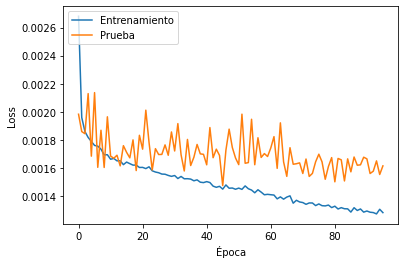

In [663]:
# name = '%sE-%sH-%sH' % (n_epochs, n_hours_b, n_hours_f)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
# plt.savefig('./models/%s/%s/entrenamiento.png' % (red_name, test_station))
plt.show()

In [664]:
# name = test_station
# hist_df = pd.DataFrame(history.history)
# hist_df.insert(0, "Estacion'", [name] * n_epochs)
# with open('./models/%s/%s/entrenamiento.json' % (red_name, test_station), 'w') as f:
#     hist_df.to_csv(f)
# model.save('./models/%s/%s/red.h5' % (red_name, test_station))
# joblib.dump(reframed_scaler_X, './models/%s/%s/scaler_X.scaler' % (red_name, test_station))
# joblib.dump(reframed_scaler_Y, './models/%s/%s/scaler_Y.scaler' % (red_name, test_station))

In [665]:
# train_predictions = model.predict(train_X)
# test_predictions = model.predict(test_X)

# print("TRAIN - R2 (KERAS) PM2.5 =>", model.evaluate(train_X, train_y, verbose=0, batch_size=train_y.shape[0])[-1])
# print("TRAIN - R2 (SKLEARN) PM2.5 =>", r2_score(train_y.reshape(train_y.shape[0], train_y.shape[2]), train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[2])))
# print("-----------------------------------------")
# print("TEST - R2 (KERAS) PM2.5 =>", model.evaluate(test_X, test_y, verbose=0, batch_size=test_y.shape[0])[-1])
# print("TEST - R2 (SKLEARN) PM2.5 =>", r2_score(test_y.reshape(test_y.shape[0], test_y.shape[2]), test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[2])))

In [666]:
# _train_predictions = train_predictions.reshape(train_predictions.shape[0], n_hours_f, len(output_columns))
# _test_predictions = test_predictions.reshape(test_predictions.shape[0], n_hours_f, len(output_columns))

# _train_y = train_y.reshape(train_y.shape[0], n_hours_f, len(output_columns))
# _test_y = test_y.reshape(test_y.shape[0], n_hours_f, len(output_columns))

# for var in range(len(output_columns)):
#     print("TRAIN - R2 (SKLEARN) %s = %s>" % (output_columns[var], r2_score(_train_y[:,:,var], _train_predictions[:,:,var])))
#     print("TEST - R2 (SKLEARN) %s = %s>" % (output_columns[var], r2_score(_test_y[:,:,var], _test_predictions[:,:,var])))
#     print("======================================================")

In [667]:
columns_name = []
for x in range(0, 2):
    if x == 0:
        for column in __df_test.columns.values[n_features_b:n_features_b + (n_hours_f * len(output_columns))]:
            columns_name.append(column + ' ' + 'VALOR REAL')
    else:
        for column in __df_test.columns.values[n_features_b:n_features_b + (n_hours_f * len(output_columns))]:
            columns_name.append(column + ' ' + 'VALOR RED')
values = []

for x in range(test_y.shape[0]):
#     print(train_y[x][0], test_predictions[x][0])
    a=test_y[x][0]
    b=test_predictions[x][0]
    yreal=scaler_Y.inverse_transform(np.expand_dims(a, axis=0))
    ypred=scaler_Y.inverse_transform(np.expand_dims(b, axis=0))
    yreal=yreal[0,:]
    ypred=ypred[0,:]
    #values.append(np.concatenate((train_y[x][0], test_predictions[x][0])))
    values.append(np.concatenate((yreal,ypred)))
print(np.asarray(values).shape)
df_export = pd.DataFrame(values, columns=columns_name)

(61152, 2)


In [668]:
df_export.head()

,pm25 (t+1) VALOR REAL,pm25 (t+1) VALOR RED
0,39.0,23.317688
1,54.0,37.993111
2,23.0,24.311375
3,7.0,15.531303
4,27.0,53.489029


In [669]:
# columns_name = []
# for x in range(0, 2):
#     if x == 0:
#         for column in __df_test.columns.values[n_features_b:n_features_b + (n_hours_f * len(output_columns))]:
#             columns_name.append(column + ' ' + 'VALOR REAL')
#     else:
#         for column in __df_test.columns.values[n_features_b:n_features_b + (n_hours_f * len(output_columns))]:
#             columns_name.append(column + ' ' + 'VALOR RED')
# values = []
# test_predictions_old = model.predict(test_X_old)
# for x in range(test_y_old.shape[0]):
# #     print(train_y[x][0], test_predictions[x][0])
#     a=test_y_old[x][0]
#     b=test_predictions_old[x][0]
#     yreal=scaler_Y.inverse_transform(np.expand_dims(a, axis=0))
#     ypred=scaler_Y.inverse_transform(np.expand_dims(b, axis=0))
#     yreal=yreal[0,:]
#     ypred=ypred[0,:]
#     #values.append(np.concatenate((train_y[x][0], test_predictions[x][0])))
#     values.append(np.concatenate((yreal,ypred)))
# print(np.asarray(values).shape)
# df_export_old = pd.DataFrame(values, columns=columns_name)
# df_export_old.to_csv("LSTM_PredOld_"+str(test_station)+"_"+str(total_station)+".txt")

In [670]:
# a=df_export_old.loc[:,['pm25 (t+1) VALOR REAL','pm25 (t+1) VALOR RED']]
# print(a.head())
# print(r2_score(a.iloc[:,0],a.iloc[:,1]))
# a3=np.concatenate((a.iloc[:,0],a.iloc[:,0]))
# a4=np.concatenate((a.iloc[:,1],a.iloc[:,1]))
# print("xxxxxxdoble +-")
# print(r2_score(a3,a4))
# print(a3.shape)
# fils=a.shape[0]
# fils
# topf=np.floor(fils/4)
# print(topf)
# print("xxxxxx +-")
# print(r2_score(a.iloc[0:int(fils*0.7),0],a.iloc[0:int(fils*0.7),1]))
# print("verano +-")
# print(r2_score(a.iloc[0:int(topf),0],a.iloc[0:int(topf),1]))
# print("otonho +-")
# print(r2_score(a.iloc[int(topf):int(2*topf),0],a.iloc[int(topf):int(2*topf),1]))
# print("invierno +-")
# print(r2_score(a.iloc[int(2*topf):int(3*topf),0],a.iloc[int(2*topf):int(3*topf),1]))
# print("primavera +-")
# print(r2_score(a.iloc[int(3*topf):int(4*topf),0],a.iloc[int(3*topf):int(4*topf),1]))
# print("medio año +-")
# print(r2_score(a.iloc[int(0*topf):int(2*topf),0],a.iloc[int(0*topf):int(2*topf),1]))
# print("medio año final +-")
# print(r2_score(a.iloc[int(2*topf):int(4*topf),0],a.iloc[int(2*topf):int(4*topf),1]))


In [671]:
# df_export.to_csv('comparar/LSTM-%s.csv' % test_station)
df_export.to_csv("LSTM_Pred_"+str(test_station)+"_"+str(total_station)+".txt")

In [672]:
df_export.shape

(61152, 2)

In [673]:
# a1 = pd.read_csv('LSTM_Pred_Cerrillos_7.txt')
# print(a1.head())
# print(a1.shape)
# print(a1.columns)
# print(a1.loc[:,'pm25 (t+1) VALOR REAL'])
# a2=a1.loc[:,['pm25 (t+1) VALOR REAL','pm25 (t+1) VALOR RED']]
# # a1.drop('Unnamed: 0', inplace=True, axis=1)
# print(a2.head())
# a=a2.to_numpy()
# # a=df_export.to_numpy()
# print(a.shape)
# print(r2_score(a[:,0],a[:,1]))
# corr_matrix = np.corrcoef(a[:,0],a[:,1])
# print(corr_matrix**2)
# f1 = plt.figure()
# nsamplesf=500
# f1 = plt.figure()
# plt.xlabel("Sample (1 hour ahead)")
# plt.ylabel("PM2.5")
# plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,0],'-r',label='Real')
# plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,1],'--g',label='Predicted')
# plt.legend(loc='upper right')
# plt.show()

<Figure size 432x288 with 0 Axes>

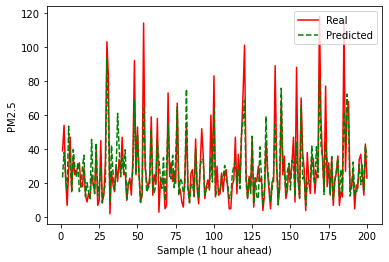

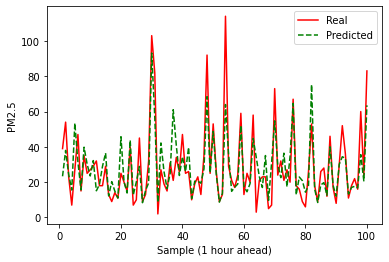

In [674]:
a=df_export.to_numpy()
f1 = plt.figure()
nsamplesf=200
if n_hours_f > 1:
  plt.xlabel("Hour")
  plt.ylabel("PM2.5")
  plt.plot(range(24),a[0,0:24],'-r',label='Real')
  plt.plot(range(24),a[0,24:],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig("Ejm1_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')
  f1 = plt.figure()
  plt.xlabel("Hour")
  plt.ylabel("PM2.5")
  plt.plot(range(24),a[100,0:24],'-r',label='Real')
  plt.plot(range(24),a[100,24:],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig("Ejm2_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')
  f1 = plt.figure()
  plt.xlabel("Sample (1 hour ahead)")
  plt.ylabel("PM2.5")
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,0],'-r',label='Real')
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,24],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig(str(test_station)+"_h1_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')
  f1 = plt.figure()
  plt.xlabel("Sample (2 hours ahead)")
  plt.ylabel("PM2.5")
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,1],'-r',label='Real')
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,25],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig(str(test_station)+"_h2_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')
  f1 = plt.figure()
  plt.xlabel("Sample (6 hours ahead)")
  plt.ylabel("PM2.5")
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,6],'-r',label='Real')
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,30],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig(str(test_station)+"_h6_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')
  f1 = plt.figure()
  plt.xlabel("Sample (12 hours ahead)")
  plt.ylabel("PM2.5")
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,12],'-r',label='Real')
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,36],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig(str(test_station)+"_h12_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')
  f1 = plt.figure()
  plt.xlabel("Sample (24 hours ahead)")
  plt.ylabel("PM2.5")
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,23],'-r',label='Real')
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,47],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig(str(test_station)+"_h24_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')
else:
  f1 = plt.figure()
  plt.xlabel("Sample (1 hour ahead)")
  plt.ylabel("PM2.5")
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,0],'-r',label='Real')
  plt.plot(range(1,nsamplesf+1),a[0:nsamplesf,1],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig("1h_200_"+str(test_station)+"_h1_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')
  f1 = plt.figure()
  plt.xlabel("Sample (1 hour ahead)")
  plt.ylabel("PM2.5")
  plt.plot(range(1,100+1),a[0:100,0],'-r',label='Real')
  plt.plot(range(1,100+1),a[0:100,1],'--g',label='Predicted')
  plt.legend(loc='upper right')
  plt.show()
  f1.savefig("1h_100_"+str(test_station)+"_h1_"+str(test_station)+"_"+str(total_station)+".pdf", bbox_inches='tight')


In [675]:
#4. GRU
red_name = 'GRU'
checkpoint.best=-np.inf
model = Sequential()
# model.add(Dropout(0.1))
model.add(GRU(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(GRU(50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(GRU(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(GRU(30, return_sequences=True, activation='tanh'))
model.add(TimeDistributed(Dense((n_hours_f * len(output_columns)), activation='linear')))
# model.add(Dense(total_hours))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mape', r_square])
# history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1)
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1, callbacks=[early_stopping,checkpoint])

model = tf.keras.models.load_model(filepath,custom_objects={"r_square": r_square})
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)


Epoch 1/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0031 - mse: 0.0031 - mape: 492.5910 - r_square: 0.1856
Epoch 1: val_r_square improved from -inf to 0.55813, saving model to bestmodel.hdf5
189/189 [==============================] - 10s 31ms/step - loss: 0.0031 - mse: 0.0031 - mape: 490.0458 - r_square: 0.1888 - val_loss: 0.0020 - val_mse: 0.0020 - val_mape: 67.9609 - val_r_square: 0.5581
Epoch 2/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mape: 354.5513 - r_square: 0.4834
Epoch 2: val_r_square did not improve from 0.55813
189/189 [==============================] - 5s 26ms/step - loss: 0.0020 - mse: 0.0020 - mape: 352.8697 - r_square: 0.4833 - val_loss: 0.0022 - val_mse: 0.0022 - val_mape: 60.9480 - val_r_square: 0.5058
Epoch 3/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 223.7617 - r_square: 0.5073
Epoch 3: val_r_square improved from 0.55813 to 0.59813, saving model to bes

189/189 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 78.5353 - r_square: 0.5746
Epoch 22: val_r_square did not improve from 0.65518
189/189 [==============================] - 4s 23ms/step - loss: 0.0016 - mse: 0.0016 - mape: 78.5353 - r_square: 0.5746 - val_loss: 0.0018 - val_mse: 0.0018 - val_mape: 61.6209 - val_r_square: 0.6071
Epoch 23/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 380.5625 - r_square: 0.5800
Epoch 23: val_r_square did not improve from 0.65518
189/189 [==============================] - 5s 25ms/step - loss: 0.0016 - mse: 0.0016 - mape: 378.4237 - r_square: 0.5802 - val_loss: 0.0020 - val_mse: 0.0020 - val_mape: 68.2534 - val_r_square: 0.5699
Epoch 24/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 197.9996 - r_square: 0.5831
Epoch 24: val_r_square did not improve from 0.65518
189/189 [==============================] - 4s 21ms/step - loss: 0.00

189/189 [==============================] - 6s 30ms/step - loss: 0.0015 - mse: 0.0015 - mape: 409.3405 - r_square: 0.6018 - val_loss: 0.0018 - val_mse: 0.0018 - val_mape: 62.2300 - val_r_square: 0.6124
Epoch 44/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 405.4159 - r_square: 0.5997
Epoch 44: val_r_square did not improve from 0.65518
189/189 [==============================] - 5s 26ms/step - loss: 0.0015 - mse: 0.0015 - mape: 405.0409 - r_square: 0.6006 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 63.5386 - val_r_square: 0.6398
Epoch 45/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 339.4795 - r_square: 0.5979
Epoch 45: val_r_square did not improve from 0.65518
189/189 [==============================] - 4s 23ms/step - loss: 0.0016 - mse: 0.0016 - mape: 337.8232 - r_square: 0.5984 - val_loss: 0.0019 - val_mse: 0.0019 - val_mape: 69.5837 - val_r_square: 0.5869
Epoch 46/1000
186/189 [==========

Epoch 65/1000
189/189 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mape: 373.0213 - r_square: 0.6297
Epoch 65: val_r_square did not improve from 0.66779
189/189 [==============================] - 7s 38ms/step - loss: 0.0014 - mse: 0.0014 - mape: 373.0213 - r_square: 0.6297 - val_loss: 0.0018 - val_mse: 0.0018 - val_mape: 62.0299 - val_r_square: 0.6054
Epoch 66/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mape: 372.8976 - r_square: 0.6275
Epoch 66: val_r_square did not improve from 0.66779
189/189 [==============================] - 5s 26ms/step - loss: 0.0014 - mse: 0.0014 - mape: 369.3124 - r_square: 0.6277 - val_loss: 0.0018 - val_mse: 0.0018 - val_mape: 69.3704 - val_r_square: 0.6111
Epoch 67/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mape: 156.4332 - r_square: 0.6318
Epoch 67: val_r_square did not improve from 0.66779
189/189 [==============================] - 4s 22ms/s

187/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 138.3297 - r_square: 0.6569
Epoch 86: val_r_square did not improve from 0.67064
189/189 [==============================] - 4s 21ms/step - loss: 0.0013 - mse: 0.0013 - mape: 137.8052 - r_square: 0.6546 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 64.6525 - val_r_square: 0.6378
Epoch 87/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 379.9242 - r_square: 0.6565
Epoch 87: val_r_square did not improve from 0.67064
189/189 [==============================] - 4s 20ms/step - loss: 0.0013 - mse: 0.0013 - mape: 377.9339 - r_square: 0.6565 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 56.2957 - val_r_square: 0.6462
Epoch 88/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 333.5457 - r_square: 0.6610
Epoch 88: val_r_square did not improve from 0.67064
189/189 [==============================] - 4s 20ms/step - loss: 0.

189/189 [==============================] - 4s 20ms/step - loss: 0.0013 - mse: 0.0013 - mape: 390.2681 - r_square: 0.6644 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 63.4215 - val_r_square: 0.6507
Epoch 108/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 288.5024 - r_square: 0.6667
Epoch 108: val_r_square did not improve from 0.67064
189/189 [==============================] - 4s 20ms/step - loss: 0.0013 - mse: 0.0013 - mape: 287.0499 - r_square: 0.6678 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 57.5423 - val_r_square: 0.6174
Epoch 109/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 161.2841 - r_square: 0.6665
Epoch 109: val_r_square did not improve from 0.67064
189/189 [==============================] - 4s 20ms/step - loss: 0.0013 - mse: 0.0013 - mape: 160.7545 - r_square: 0.6660 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 69.1935 - val_r_square: 0.6333
Epoch 110/1000
187/189 [=====

Epoch 129/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 325.1234 - r_square: 0.6767
Epoch 129: val_r_square improved from 0.67064 to 0.67268, saving model to bestmodel.hdf5
189/189 [==============================] - 4s 20ms/step - loss: 0.0013 - mse: 0.0013 - mape: 323.4828 - r_square: 0.6769 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 58.4134 - val_r_square: 0.6727
Epoch 130/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 347.8402 - r_square: 0.6760
Epoch 130: val_r_square did not improve from 0.67268
189/189 [==============================] - 4s 21ms/step - loss: 0.0013 - mse: 0.0013 - mape: 347.5521 - r_square: 0.6759 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 58.4664 - val_r_square: 0.6552
Epoch 131/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 390.0120 - r_square: 0.6810
Epoch 131: val_r_square did not improve from 0.67268
189/189 [=

186/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 319.6808 - r_square: 0.6884
Epoch 150: val_r_square did not improve from 0.67326
189/189 [==============================] - 4s 20ms/step - loss: 0.0012 - mse: 0.0012 - mape: 316.7029 - r_square: 0.6889 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 60.6827 - val_r_square: 0.6463
Epoch 151/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 346.9321 - r_square: 0.6903
Epoch 151: val_r_square did not improve from 0.67326
189/189 [==============================] - 4s 20ms/step - loss: 0.0012 - mse: 0.0012 - mape: 345.1262 - r_square: 0.6903 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 60.0289 - val_r_square: 0.6451
Epoch 152/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 252.3028 - r_square: 0.6901
Epoch 152: val_r_square did not improve from 0.67326
189/189 [==============================] - 4s 20ms/step - los

187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 329.3747 - r_square: 0.6991
Epoch 171: val_r_square did not improve from 0.67326
189/189 [==============================] - 4s 20ms/step - loss: 0.0012 - mse: 0.0012 - mape: 327.7263 - r_square: 0.6991 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 59.2812 - val_r_square: 0.6716
Epoch 172/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 339.4422 - r_square: 0.6934
Epoch 172: val_r_square did not improve from 0.67326
189/189 [==============================] - 4s 20ms/step - loss: 0.0012 - mse: 0.0012 - mape: 337.6148 - r_square: 0.6921 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 60.0531 - val_r_square: 0.6492
Epoch 173/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 80.4348 - r_square: 0.6964
Epoch 173: val_r_square did not improve from 0.67326
189/189 [==============================] - 4s 20ms/step - loss

Epoch 192/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 349.1809 - r_square: 0.6937
Epoch 192: val_r_square did not improve from 0.68211
189/189 [==============================] - 4s 20ms/step - loss: 0.0012 - mse: 0.0012 - mape: 345.8778 - r_square: 0.6931 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 58.3391 - val_r_square: 0.6730
Epoch 193/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 242.5404 - r_square: 0.7023
Epoch 193: val_r_square did not improve from 0.68211
189/189 [==============================] - 4s 20ms/step - loss: 0.0012 - mse: 0.0012 - mape: 241.4123 - r_square: 0.7013 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 61.4989 - val_r_square: 0.6376
Epoch 194/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 252.7571 - r_square: 0.7015
Epoch 194: val_r_square did not improve from 0.68211
189/189 [==============================] - 4s 

187/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 336.5659 - r_square: 0.7058
Epoch 213: val_r_square did not improve from 0.68211
189/189 [==============================] - 4s 20ms/step - loss: 0.0011 - mse: 0.0011 - mape: 334.7585 - r_square: 0.7060 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 59.9556 - val_r_square: 0.6681
Epoch 214/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 308.4369 - r_square: 0.7061
Epoch 214: val_r_square did not improve from 0.68211
189/189 [==============================] - 4s 20ms/step - loss: 0.0011 - mse: 0.0011 - mape: 306.8464 - r_square: 0.7061 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 60.6291 - val_r_square: 0.6652
Epoch 215/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 221.6969 - r_square: 0.7035
Epoch 215: val_r_square did not improve from 0.68211
189/189 [==============================] - 4s 20ms/step - los

187/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 257.4525 - r_square: 0.7122
Epoch 234: val_r_square did not improve from 0.68723
189/189 [==============================] - 4s 20ms/step - loss: 0.0011 - mse: 0.0011 - mape: 256.2359 - r_square: 0.7124 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 64.4615 - val_r_square: 0.6670
Epoch 235/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 314.8956 - r_square: 0.7107
Epoch 235: val_r_square did not improve from 0.68723
189/189 [==============================] - 4s 20ms/step - loss: 0.0011 - mse: 0.0011 - mape: 313.1713 - r_square: 0.7108 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 61.2435 - val_r_square: 0.6415
Epoch 236/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 348.8907 - r_square: 0.7133
Epoch 236: val_r_square did not improve from 0.68723
189/189 [==============================] - 4s 20ms/step - los

189/189 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 254.7033 - r_square: 0.7147
Epoch 255: val_r_square did not improve from 0.68723
189/189 [==============================] - 5s 24ms/step - loss: 0.0011 - mse: 0.0011 - mape: 254.7033 - r_square: 0.7147 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 67.8848 - val_r_square: 0.6509
Epoch 256/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 329.7637 - r_square: 0.7103
Epoch 256: val_r_square did not improve from 0.68723
189/189 [==============================] - 5s 24ms/step - loss: 0.0011 - mse: 0.0011 - mape: 326.5748 - r_square: 0.7102 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 70.6530 - val_r_square: 0.6599
Epoch 257/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 209.4263 - r_square: 0.7148
Epoch 257: val_r_square did not improve from 0.68723
189/189 [==============================] - 4s 23ms/step - los

In [676]:
# model = load_model("./models/GRU/%s/red.h5" % test_station,
#                   custom_objects={"r_square": r_square}) 
try:
    os.remove(filepath)
except OSError as e:  ## if failed, report it back to the user ##
    print ("Error: %s - %s." % (e.filename, e.strerror))
    

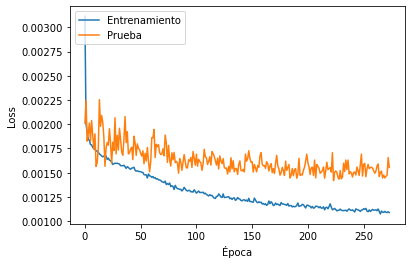

In [677]:
# name = '%sE-%sH-%sH' % (n_epochs, n_hours_b, n_hours_f)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
# plt.savefig('./models/%s/%s/entrenamiento.png' % (red_name, test_station))
plt.show()

In [678]:
# name = test_station
# hist_df = pd.DataFrame(history.history)
# hist_df.insert(0, "Estacion'", [name] * n_epochs)
# with open('./models/%s/%s/entrenamiento.json' % (red_name, test_station), 'w') as f:
#     hist_df.to_csv(f)
# model.save('./models/%s/%s/red.h5' % (red_name, test_station))
# joblib.dump(reframed_scaler_X, './models/%s/%s/scaler_X.scaler' % (red_name, test_station))
# joblib.dump(reframed_scaler_Y, './models/%s/%s/scaler_Y.scaler' % (red_name, test_station))

In [679]:
print("TRAIN - R2 (KERAS) PM2.5 =>", model.evaluate(train_X, train_y, verbose=0, batch_size=train_y.shape[0])[-1])
print("TRAIN - R2 (SKLEARN) PM2.5 =>", r2_score(train_y.reshape(train_y.shape[0], train_y.shape[2]), train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[2])))
print("-----------------------------------------")
print("TEST - R2 (KERAS) PM2.5 =>", model.evaluate(test_X, test_y, verbose=0, batch_size=test_y.shape[0])[-1])
print("TEST - R2 (SKLEARN) PM2.5 =>", r2_score(test_y.reshape(test_y.shape[0], test_y.shape[2]), test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[2])))

TRAIN - R2 (KERAS) PM2.5 => 0.7646291851997375
TRAIN - R2 (SKLEARN) PM2.5 => 0.7646291368441904
-----------------------------------------
TEST - R2 (KERAS) PM2.5 => 0.6881159543991089
TEST - R2 (SKLEARN) PM2.5 => 0.6881159203346727


In [680]:
# _train_predictions = train_predictions.reshape(train_predictions.shape[0], n_hours_f, len(output_columns))
# _test_predictions = test_predictions.reshape(test_predictions.shape[0], n_hours_f, len(output_columns))

# _train_y = train_y.reshape(train_y.shape[0], n_hours_f, len(output_columns))
# _test_y = test_y.reshape(test_y.shape[0], n_hours_f, len(output_columns))

# for var in range(len(output_columns)):
#     print("TRAIN - R2 (SKLEARN) %s = %s>" % (output_columns[var], r2_score(_train_y[:,:,var], _train_predictions[:,:,var])))
#     print("TEST - R2 (SKLEARN) %s = %s>" % (output_columns[var], r2_score(_test_y[:,:,var], _test_predictions[:,:,var])))
#     print("======================================================")

In [681]:
print("********************************************++++******")
print("TRAIN: 4.GRU completo 3 niveles")
print("************************************************+++++**")
metrics_calculate_te(train_y,train_predictions)

print("********************************************++++******")
print("TEST: 4. GRU completo 3 niveles")
print("************************************************+++++**")
metrics_calculate_te(test_y,test_predictions)

********************************************++++******
TRAIN: 4.GRU completo 3 niveles
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.76462914]
TEST - R2 (SKLEARN) PM2.5 => 0.7646291376913383
TEST - MSE (SKLEARN) PM2.5 => 102.28610475532986
TEST - MAE (SKLEARN) PM2.5 => 6.508943119930894
TEST - MAPE (SKLEARN) PM2.5 => 0.4641375500140709
TEST - MedianAE (SKLEARN) PM2.5 => 4.254852771759033
0.7646291376913383 	 102.28610475532986 	 4.254852771759033 	 0.4641375500140709 	 4.254852771759033
********************************************++++******
TEST: 4. GRU completo 3 niveles
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.68811592]
TEST - R2 (SKLEARN) PM2.5 => 0.6881159155390788
TEST - MSE (SKLEARN) PM2.5 => 158.44024488723957
TEST - MAE (SKLEARN) PM2.5 => 8.501022211723088
TEST - MAPE (SKLEARN) PM2.5 => 0.5141648597559697
TEST - MedianAE (SKLEARN) PM2.5 => 5.888925552368164
0.6881159155390

In [682]:
f = open("experiments_"+str(test_station)+"_"+str(total_station)+"_results.txt", mode = "a")
f.write("********************************************++++******\n")
f.write("TRAIN: 4. GRU completo 3 niveles\n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(train_y,train_predictions,f)

f.write("********************************************++++******\n")
f.write("TEST: 4. GRU completo 3 niveles\n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(test_y,test_predictions,f)

f.close()

In [683]:
# columns_name = []
# for x in range(0, 2):
#     if x == 0:
#         for column in __df_test.columns.values[n_features_b:n_features_b + (n_hours_f * len(output_columns))]:
#             columns_name.append(column + ' ' + 'VALOR REAL')
#     else:
#         for column in __df_test.columns.values[n_features_b:n_features_b + (n_hours_f * len(output_columns))]:
#             columns_name.append(column + ' ' + 'VALOR RED')
# values = []

# for x in range(test_y.shape[0]):
# #     print(train_y[x][0], test_predictions[x][0])
#     a=test_y[x][0]
#     b=test_predictions[x][0]
#     yreal=scaler_Y.inverse_transform(np.expand_dims(a, axis=0))
#     ypred=scaler_Y.inverse_transform(np.expand_dims(b, axis=0))
#     yreal=yreal[0,:]
#     ypred=ypred[0,:]
#     #values.append(np.concatenate((train_y[x][0], test_predictions[x][0])))
#     values.append(np.concatenate((yreal,ypred)))
# print(np.asarray(values).shape)
# df_export = pd.DataFrame(values, columns=columns_name)

In [684]:
# df_export.head()

In [685]:
# df_export.to_csv('./comparar/GRU-%s.csv' % test_station)
# df_export.to_csv("GRU_Pred_"+str(test_station)+"_"+str(total_station)+".txt")

In [686]:
#Experiments other baseline models
#1. LSTM simple
#2. Red neuronal multicapa
#3. Regresion lineal

In [687]:
red_name = 'LSTM'
n_epochs=1000
checkpoint.best=-np.inf
model = Sequential()
model.add(Dropout(0.1))
# model.add(Dense(512,activation='linear'))
# model.add(Dense(64))
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='tanh'))
# model.add(Dropout(0.15))
# model.add(LSTM(100, return_sequences=True, activation='linear'))
# model.add(Dropout(0.3))
# model.add(LSTM(75, return_sequences=True, activation='linear'))
model.add(TimeDistributed(Dense((n_hours_f * len(output_columns)), activation='linear')))
# model.add(Dense(total_hours))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mape', r_square])
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1, callbacks=[early_stopping,checkpoint])

model = tf.keras.models.load_model(filepath,custom_objects={"r_square": r_square})
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)


# history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1)

# train_predictions = model.predict(train_X)
# test_predictions = model.predict(test_X)

Epoch 1/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0426 - mse: 0.0426 - mape: 497.3424 - r_square: -10.2670
Epoch 1: val_r_square improved from -inf to 0.10880, saving model to bestmodel.hdf5
189/189 [==============================] - 6s 21ms/step - loss: 0.0422 - mse: 0.0422 - mape: 493.5458 - r_square: -10.1017 - val_loss: 0.0040 - val_mse: 0.0040 - val_mape: 107.8497 - val_r_square: 0.1088
Epoch 2/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0027 - mape: 672.1489 - r_square: 0.3051
Epoch 2: val_r_square improved from 0.10880 to 0.36881, saving model to bestmodel.hdf5
189/189 [==============================] - 3s 19ms/step - loss: 0.0027 - mse: 0.0027 - mape: 665.9186 - r_square: 0.3069 - val_loss: 0.0029 - val_mse: 0.0029 - val_mape: 83.8497 - val_r_square: 0.3688
Epoch 3/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 0.0023 - mape: 591.9095 - r_square: 0.4142
Epoch 3: val_r_square improved from

188/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 258.2305 - r_square: 0.5850
Epoch 21: val_r_square improved from 0.63425 to 0.65153, saving model to bestmodel.hdf5
189/189 [==============================] - 3s 18ms/step - loss: 0.0016 - mse: 0.0016 - mape: 258.1531 - r_square: 0.5855 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 61.1392 - val_r_square: 0.6515
Epoch 22/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 298.2156 - r_square: 0.5886
Epoch 22: val_r_square did not improve from 0.65153
189/189 [==============================] - 3s 18ms/step - loss: 0.0016 - mse: 0.0016 - mape: 296.6564 - r_square: 0.5886 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 60.9879 - val_r_square: 0.6388
Epoch 23/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mape: 254.4530 - r_square: 0.5883
Epoch 23: val_r_square did not improve from 0.65153
189/189 [=====================

187/189 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mape: 245.5253 - r_square: 0.6075
Epoch 42: val_r_square did not improve from 0.65153
189/189 [==============================] - 3s 18ms/step - loss: 0.0015 - mse: 0.0015 - mape: 244.4191 - r_square: 0.6080 - val_loss: 0.0019 - val_mse: 0.0019 - val_mape: 66.3635 - val_r_square: 0.5774
Epoch 43/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mape: 199.1935 - r_square: 0.6052
Epoch 43: val_r_square did not improve from 0.65153
189/189 [==============================] - 3s 18ms/step - loss: 0.0015 - mse: 0.0015 - mape: 199.0474 - r_square: 0.6050 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 56.1110 - val_r_square: 0.6289
Epoch 44/1000
189/189 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mape: 190.7534 - r_square: 0.6066
Epoch 44: val_r_square did not improve from 0.65153
189/189 [==============================] - 3s 18ms/step - loss: 0.

189/189 [==============================] - 3s 18ms/step - loss: 0.0014 - mse: 0.0014 - mape: 314.6646 - r_square: 0.6467 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 61.3297 - val_r_square: 0.6346
Epoch 64/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mape: 191.4101 - r_square: 0.6503
Epoch 64: val_r_square did not improve from 0.65153
189/189 [==============================] - 3s 18ms/step - loss: 0.0014 - mse: 0.0014 - mape: 191.2979 - r_square: 0.6495 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 56.5307 - val_r_square: 0.6314
Epoch 65/1000
189/189 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mape: 258.8664 - r_square: 0.6485
Epoch 65: val_r_square did not improve from 0.65153
189/189 [==============================] - 3s 18ms/step - loss: 0.0014 - mse: 0.0014 - mape: 258.8664 - r_square: 0.6485 - val_loss: 0.0017 - val_mse: 0.0017 - val_mape: 76.5225 - val_r_square: 0.6269
Epoch 66/1000
188/189 [==========

Epoch 85/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 186.5759 - r_square: 0.6664
Epoch 85: val_r_square did not improve from 0.65809
189/189 [==============================] - 3s 17ms/step - loss: 0.0013 - mse: 0.0013 - mape: 186.4561 - r_square: 0.6663 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 71.6442 - val_r_square: 0.6377
Epoch 86/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 351.8990 - r_square: 0.6634
Epoch 86: val_r_square improved from 0.65809 to 0.66890, saving model to bestmodel.hdf5
189/189 [==============================] - 3s 18ms/step - loss: 0.0013 - mse: 0.0013 - mape: 351.5577 - r_square: 0.6641 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 59.6348 - val_r_square: 0.6689
Epoch 87/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mape: 333.0630 - r_square: 0.6706
Epoch 87: val_r_square did not improve from 0.66890
189/189 [=======

186/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 320.4489 - r_square: 0.6776
Epoch 106: val_r_square did not improve from 0.66903
189/189 [==============================] - 3s 18ms/step - loss: 0.0012 - mse: 0.0012 - mape: 317.2679 - r_square: 0.6776 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 63.1733 - val_r_square: 0.6596
Epoch 107/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 391.4700 - r_square: 0.6780
Epoch 107: val_r_square did not improve from 0.66903
189/189 [==============================] - 3s 18ms/step - loss: 0.0012 - mse: 0.0012 - mape: 387.5266 - r_square: 0.6787 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 61.7207 - val_r_square: 0.6688
Epoch 108/1000
189/189 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 255.0824 - r_square: 0.6748
Epoch 108: val_r_square did not improve from 0.66903
189/189 [==============================] - 3s 17ms/step - los

186/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 254.5363 - r_square: 0.6879
Epoch 127: val_r_square did not improve from 0.66903
189/189 [==============================] - 3s 17ms/step - loss: 0.0012 - mse: 0.0012 - mape: 252.3699 - r_square: 0.6879 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 60.1982 - val_r_square: 0.6396
Epoch 128/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 426.6751 - r_square: 0.6829
Epoch 128: val_r_square did not improve from 0.66903
189/189 [==============================] - 3s 17ms/step - loss: 0.0012 - mse: 0.0012 - mape: 422.3763 - r_square: 0.6828 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 57.8094 - val_r_square: 0.6511
Epoch 129/1000
189/189 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 350.1595 - r_square: 0.6868
Epoch 129: val_r_square did not improve from 0.66903
189/189 [==============================] - 3s 17ms/step - los

186/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 313.2698 - r_square: 0.6871
Epoch 148: val_r_square did not improve from 0.66945
189/189 [==============================] - 3s 17ms/step - loss: 0.0012 - mse: 0.0012 - mape: 310.1620 - r_square: 0.6878 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 62.0325 - val_r_square: 0.6553
Epoch 149/1000
189/189 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 250.2793 - r_square: 0.6867
Epoch 149: val_r_square did not improve from 0.66945
189/189 [==============================] - 3s 17ms/step - loss: 0.0012 - mse: 0.0012 - mape: 250.2793 - r_square: 0.6867 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 61.8045 - val_r_square: 0.6536
Epoch 150/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 240.8326 - r_square: 0.6866
Epoch 150: val_r_square did not improve from 0.66945
189/189 [==============================] - 3s 17ms/step - los

189/189 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 295.9123 - r_square: 0.6927
Epoch 169: val_r_square did not improve from 0.66945
189/189 [==============================] - 3s 18ms/step - loss: 0.0012 - mse: 0.0012 - mape: 295.9123 - r_square: 0.6927 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 54.2756 - val_r_square: 0.6549
Epoch 170/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 271.3496 - r_square: 0.6924
Epoch 170: val_r_square did not improve from 0.66945
189/189 [==============================] - 3s 18ms/step - loss: 0.0012 - mse: 0.0012 - mape: 271.1003 - r_square: 0.6926 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 53.0831 - val_r_square: 0.6444
Epoch 171/1000
189/189 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 226.3870 - r_square: 0.6924
Epoch 171: val_r_square improved from 0.66945 to 0.67097, saving model to bestmodel.hdf5
189/189 [================

188/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 207.8170 - r_square: 0.6901
Epoch 190: val_r_square did not improve from 0.67097
189/189 [==============================] - 3s 17ms/step - loss: 0.0012 - mse: 0.0012 - mape: 207.6292 - r_square: 0.6907 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 53.0129 - val_r_square: 0.6375
Epoch 191/1000
189/189 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 251.0252 - r_square: 0.6908
Epoch 191: val_r_square did not improve from 0.67097
189/189 [==============================] - 3s 18ms/step - loss: 0.0012 - mse: 0.0012 - mape: 251.0252 - r_square: 0.6908 - val_loss: 0.0015 - val_mse: 0.0015 - val_mape: 56.5387 - val_r_square: 0.6673
Epoch 192/1000
189/189 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 242.5154 - r_square: 0.6938
Epoch 192: val_r_square did not improve from 0.67097
189/189 [==============================] - 3s 17ms/step - los

188/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 223.2875 - r_square: 0.6964
Epoch 211: val_r_square did not improve from 0.67498
189/189 [==============================] - 3s 18ms/step - loss: 0.0012 - mse: 0.0012 - mape: 223.1154 - r_square: 0.6966 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 62.2501 - val_r_square: 0.6506
Epoch 212/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 200.7842 - r_square: 0.6977
Epoch 212: val_r_square did not improve from 0.67498
189/189 [==============================] - 3s 18ms/step - loss: 0.0012 - mse: 0.0012 - mape: 199.9422 - r_square: 0.6978 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 52.7831 - val_r_square: 0.6533
Epoch 213/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 321.8074 - r_square: 0.7001
Epoch 213: val_r_square did not improve from 0.67498
189/189 [==============================] - 4s 19ms/step - los

189/189 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 192.8402 - r_square: 0.6992
Epoch 232: val_r_square did not improve from 0.67498
189/189 [==============================] - 3s 18ms/step - loss: 0.0012 - mse: 0.0012 - mape: 192.8402 - r_square: 0.6992 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 55.5757 - val_r_square: 0.6498
Epoch 233/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mape: 303.8473 - r_square: 0.7039
Epoch 233: val_r_square did not improve from 0.67498
189/189 [==============================] - 3s 18ms/step - loss: 0.0011 - mse: 0.0011 - mape: 300.8597 - r_square: 0.7029 - val_loss: 0.0016 - val_mse: 0.0016 - val_mape: 62.9414 - val_r_square: 0.6558
Epoch 234/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mape: 214.1575 - r_square: 0.6998
Epoch 234: val_r_square did not improve from 0.67498
189/189 [==============================] - 3s 18ms/step - los

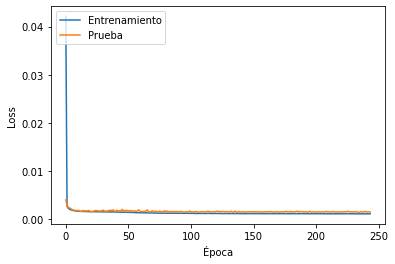

In [688]:
try:
    os.remove(filepath)
except OSError as e:  ## if failed, report it back to the user ##
    print ("Error: %s - %s." % (e.filename, e.strerror))
    
# name = '%sE-%sH-%sH' % (n_epochs, n_hours_b, n_hours_f)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
# plt.savefig('./models/%s/%s/entrenamiento.png' % (red_name, test_station))
plt.show()

In [689]:
print("********************************************++++******")
print("TRAIN: 5. LSTM simple 1 nivel")
print("************************************************+++++**")
metrics_calculate_te(train_y,train_predictions)

print("********************************************++++******")
print("TEST: 5. LSTM simple 1 nivel")
print("************************************************+++++**")
metrics_calculate_te(test_y,test_predictions)

********************************************++++******
TRAIN: 5. LSTM simple 1 nivel
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.70071678]
TEST - R2 (SKLEARN) PM2.5 => 0.7007167801466553
TEST - MSE (SKLEARN) PM2.5 => 130.0607665586357
TEST - MAE (SKLEARN) PM2.5 => 7.130559238047722
TEST - MAPE (SKLEARN) PM2.5 => 0.46255852204343895
TEST - MedianAE (SKLEARN) PM2.5 => 4.349293231964111
0.7007167801466553 	 130.0607665586357 	 4.349293231964111 	 0.46255852204343895 	 4.349293231964111
********************************************++++******
TEST: 5. LSTM simple 1 nivel
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.6683229]
TEST - R2 (SKLEARN) PM2.5 => 0.6683229014317943
TEST - MSE (SKLEARN) PM2.5 => 168.49529469087167
TEST - MAE (SKLEARN) PM2.5 => 8.60295887829698
TEST - MAPE (SKLEARN) PM2.5 => 0.48376833417850784
TEST - MedianAE (SKLEARN) PM2.5 => 5.568974971771239
0.6683229014317943 	 

In [690]:
f = open("experiments_"+str(test_station)+"_"+str(total_station)+"_results.txt", mode = "a")
f.write("********************************************++++******\n")
f.write("TRAIN: 5. LSTM simple 1 \n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(train_y,train_predictions,f)

f.write("********************************************++++******\n")
f.write("TEST: 5. LSTM simple 1 \n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(test_y,test_predictions,f)

f.close()

In [691]:
red_name = 'FFN'
n_epochs=1000
checkpoint.best=-np.inf
model = Sequential()
model.add(Dropout(0.1))
model.add(Dense(512))
model.add(Dropout(0.1))
model.add(Dense(64))
# model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='linear'))
# # model.add(Dropout(0.15))
# # model.add(LSTM(100, return_sequences=True, activation='linear'))
# # model.add(Dropout(0.3))
# # model.add(LSTM(75, return_sequences=True, activation='linear'))
model.add(TimeDistributed(Dense((n_hours_f * len(output_columns)), activation='linear')))
# model.add(Dense(total_hours))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mape', r_square])
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1, callbacks=[early_stopping,checkpoint])

model = tf.keras.models.load_model(filepath,custom_objects={"r_square": r_square})
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)


# history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1)

# train_predictions = model.predict(train_X)
# test_predictions = model.predict(test_X)

Epoch 1/1000
188/189 [============================>.] - ETA: 0s - loss: 5.4238 - mse: 5.4238 - mape: 41317.4297 - r_square: -1560.9048
Epoch 1: val_r_square improved from -inf to -0.19263, saving model to bestmodel.hdf5
189/189 [==============================] - 3s 14ms/step - loss: 5.4180 - mse: 5.4180 - mape: 41273.1523 - r_square: -1552.6725 - val_loss: 0.0054 - val_mse: 0.0054 - val_mape: 136.5457 - val_r_square: -0.1926
Epoch 2/1000
185/189 [============================>.] - ETA: 0s - loss: 0.0163 - mse: 0.0163 - mape: 843.9038 - r_square: -3.2921
Epoch 2: val_r_square improved from -0.19263 to 0.14508, saving model to bestmodel.hdf5
189/189 [==============================] - 2s 12ms/step - loss: 0.0163 - mse: 0.0163 - mape: 833.8906 - r_square: -3.2831 - val_loss: 0.0039 - val_mse: 0.0039 - val_mape: 114.5676 - val_r_square: 0.1451
Epoch 3/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0119 - mse: 0.0119 - mape: 835.7339 - r_square: -2.1101
Epoch 3: val_r_squar

184/189 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 207.9507 - r_square: 0.5175
Epoch 21: val_r_square improved from 0.57593 to 0.58311, saving model to bestmodel.hdf5
189/189 [==============================] - 2s 13ms/step - loss: 0.0019 - mse: 0.0019 - mape: 204.8115 - r_square: 0.5187 - val_loss: 0.0019 - val_mse: 0.0019 - val_mape: 58.7188 - val_r_square: 0.5831
Epoch 22/1000
187/189 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 132.2956 - r_square: 0.5257
Epoch 22: val_r_square did not improve from 0.58311
189/189 [==============================] - 2s 11ms/step - loss: 0.0018 - mse: 0.0018 - mape: 131.9926 - r_square: 0.5251 - val_loss: 0.0020 - val_mse: 0.0020 - val_mape: 54.3487 - val_r_square: 0.5533
Epoch 23/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 302.0378 - r_square: 0.5303
Epoch 23: val_r_square did not improve from 0.58311
189/189 [=====================

Epoch 42/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mape: 258.8342 - r_square: 0.5513
Epoch 42: val_r_square did not improve from 0.60631
189/189 [==============================] - 2s 11ms/step - loss: 0.0017 - mse: 0.0017 - mape: 256.7783 - r_square: 0.5510 - val_loss: 0.0018 - val_mse: 0.0018 - val_mape: 57.6475 - val_r_square: 0.5962
Epoch 43/1000
188/189 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 129.9294 - r_square: 0.5474
Epoch 43: val_r_square did not improve from 0.60631
189/189 [==============================] - 2s 11ms/step - loss: 0.0018 - mse: 0.0018 - mape: 129.8920 - r_square: 0.5468 - val_loss: 0.0019 - val_mse: 0.0019 - val_mape: 55.9908 - val_r_square: 0.5730
Epoch 44/1000
184/189 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 355.6137 - r_square: 0.5449
Epoch 44: val_r_square improved from 0.60631 to 0.61685, saving model to bestmodel.hdf5
189/189 [=======

186/189 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mape: 231.5431 - r_square: 0.4758
Epoch 63: val_r_square did not improve from 0.63592
189/189 [==============================] - 2s 13ms/step - loss: 0.0020 - mse: 0.0020 - mape: 230.1171 - r_square: 0.4741 - val_loss: 0.0023 - val_mse: 0.0023 - val_mape: 81.1733 - val_r_square: 0.5016
Epoch 64/1000
186/189 [============================>.] - ETA: 0s - loss: 10.5022 - mse: 10.5022 - mape: 3481.6440 - r_square: -2771.0085
Epoch 64: val_r_square did not improve from 0.63592
189/189 [==============================] - 2s 13ms/step - loss: 10.3794 - mse: 10.3794 - mape: 3443.1572 - r_square: -2727.0452 - val_loss: 0.0034 - val_mse: 0.0034 - val_mape: 102.0451 - val_r_square: 0.2596
Epoch 65/1000
186/189 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0066 - mape: 1196.4246 - r_square: -0.7266
Epoch 65: val_r_square did not improve from 0.63592
189/189 [==============================] - 2s 13m

189/189 [==============================] - 2s 13ms/step - loss: 0.0018 - mse: 0.0018 - mape: 214.4781 - r_square: 0.5445 - val_loss: 0.0018 - val_mse: 0.0018 - val_mape: 55.5999 - val_r_square: 0.6058
Epoch 85/1000
185/189 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 191.8402 - r_square: 0.5487
Epoch 85: val_r_square did not improve from 0.63592
189/189 [==============================] - 2s 12ms/step - loss: 0.0018 - mse: 0.0018 - mape: 189.7928 - r_square: 0.5488 - val_loss: 0.0018 - val_mse: 0.0018 - val_mape: 54.5018 - val_r_square: 0.6087
Epoch 86/1000
184/189 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mape: 362.5170 - r_square: 0.5507
Epoch 86: val_r_square did not improve from 0.63592
189/189 [==============================] - 2s 12ms/step - loss: 0.0017 - mse: 0.0017 - mape: 356.0529 - r_square: 0.5511 - val_loss: 0.0019 - val_mse: 0.0019 - val_mape: 52.5467 - val_r_square: 0.5921
Epoch 87/1000
186/189 [==========

In [692]:
try:
    os.remove(filepath)
except OSError as e:  ## if failed, report it back to the user ##
    print ("Error: %s - %s." % (e.filename, e.strerror))
    
print("********************************************++++******")
print("TRAIN: 6. FFN")
print("************************************************+++++**")
metrics_calculate_te(train_y,train_predictions)

print("********************************************++++******")
print("TEST: 6. FFN ")
print("************************************************+++++**")
metrics_calculate_te(test_y,test_predictions)

********************************************++++******
TRAIN: 6. FFN
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.54287265]
TEST - R2 (SKLEARN) PM2.5 => 0.5428726498290428
TEST - MSE (SKLEARN) PM2.5 => 198.6557535944932
TEST - MAE (SKLEARN) PM2.5 => 9.056650247535885
TEST - MAPE (SKLEARN) PM2.5 => 0.5995898297277391
TEST - MedianAE (SKLEARN) PM2.5 => 5.859939813613892
0.5428726498290428 	 198.6557535944932 	 5.859939813613892 	 0.5995898297277391 	 5.859939813613892
********************************************++++******
TEST: 6. FFN 
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.64108104]
TEST - R2 (SKLEARN) PM2.5 => 0.6410810351667304
TEST - MSE (SKLEARN) PM2.5 => 182.33443614524413
TEST - MAE (SKLEARN) PM2.5 => 9.038476960344273
TEST - MAPE (SKLEARN) PM2.5 => 0.48853757515422447
TEST - MedianAE (SKLEARN) PM2.5 => 6.070919990539551
0.6410810351667304 	 182.33443614524413 	 6.07091999

In [693]:
f = open("experiments_"+str(test_station)+"_"+str(total_station)+"_results.txt", mode = "a")
f.write("********************************************++++******\n")
f.write("TRAIN: 6. FFN \n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(train_y,train_predictions,f)

f.write("********************************************++++******\n")
f.write("TEST: 6. FFN \n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(test_y,test_predictions,f)

f.close()

In [694]:
red_name = 'Regresion Lineal'
checkpoint.best=-np.inf
model = Sequential()
model.add(Dropout(0.))
# model.add(Dense(512))
# model.add(Dense(64))
# model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='linear'))
# # model.add(Dropout(0.15))
# # model.add(LSTM(100, return_sequences=True, activation='linear'))
# # model.add(Dropout(0.3))
# # model.add(LSTM(75, return_sequences=True, activation='linear'))
model.add(TimeDistributed(Dense((n_hours_f * len(output_columns)), activation='linear')))
# model.add(Dense(total_hours))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mape', r_square])
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1, callbacks=[early_stopping,checkpoint])

model = tf.keras.models.load_model(filepath,custom_objects={"r_square": r_square})
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)


# history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=512, validation_data=(val_X, val_y), verbose=1)

# train_predictions = model.predict(train_X)
# test_predictions = model.predict(test_X)

Epoch 1/1000
176/189 [==========================>...] - ETA: 0s - loss: 0.0213 - mse: 0.0213 - mape: 1610.9407 - r_square: -4.6714
Epoch 1: val_r_square improved from -inf to -0.72595, saving model to bestmodel.hdf5
189/189 [==============================] - 1s 3ms/step - loss: 0.0204 - mse: 0.0204 - mape: 1519.5872 - r_square: -4.4137 - val_loss: 0.0078 - val_mse: 0.0078 - val_mape: 162.0828 - val_r_square: -0.7260
Epoch 2/1000
143/189 [=====================>........] - ETA: 0s - loss: 0.0060 - mse: 0.0060 - mape: 1637.8127 - r_square: -0.5727
Epoch 2: val_r_square improved from -0.72595 to -0.23743, saving model to bestmodel.hdf5
189/189 [==============================] - 0s 1ms/step - loss: 0.0057 - mse: 0.0057 - mape: 1282.3441 - r_square: -0.5062 - val_loss: 0.0056 - val_mse: 0.0056 - val_mape: 137.9815 - val_r_square: -0.2374
Epoch 3/1000
150/189 [======================>.......] - ETA: 0s - loss: 0.0043 - mse: 0.0043 - mape: 1342.1713 - r_square: -0.1331
Epoch 3: val_r_square imp

149/189 [======================>.......] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - mape: 371.2567 - r_square: 0.4633
Epoch 21: val_r_square did not improve from 0.41376
189/189 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020 - mape: 310.2988 - r_square: 0.4715 - val_loss: 0.0030 - val_mse: 0.0030 - val_mape: 75.8204 - val_r_square: 0.3359
Epoch 22/1000
152/189 [=======================>......] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - mape: 754.0424 - r_square: 0.4498 
Epoch 22: val_r_square improved from 0.41376 to 0.44440, saving model to bestmodel.hdf5
189/189 [==============================] - 0s 1ms/step - loss: 0.0021 - mse: 0.0021 - mape: 625.8494 - r_square: 0.4511 - val_loss: 0.0025 - val_mse: 0.0025 - val_mape: 85.0769 - val_r_square: 0.4444
Epoch 23/1000
156/189 [=======================>......] - ETA: 0s - loss: 0.0022 - mse: 0.0022 - mape: 557.6921 - r_square: 0.4321
Epoch 23: val_r_square did not improve from 0.44440
189/189 [======================

159/189 [========================>.....] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - mape: 97.9801 - r_square: 0.4527 
Epoch 42: val_r_square improved from 0.46997 to 0.48103, saving model to bestmodel.hdf5
189/189 [==============================] - 0s 1ms/step - loss: 0.0021 - mse: 0.0021 - mape: 96.0644 - r_square: 0.4602 - val_loss: 0.0023 - val_mse: 0.0023 - val_mape: 84.1311 - val_r_square: 0.4810
Epoch 43/1000
162/189 [========================>.....] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 411.8530 - r_square: 0.5179
Epoch 43: val_r_square did not improve from 0.48103
189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 365.6488 - r_square: 0.5188 - val_loss: 0.0024 - val_mse: 0.0024 - val_mape: 80.0232 - val_r_square: 0.4687
Epoch 44/1000
162/189 [========================>.....] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 151.7311 - r_square: 0.5122
Epoch 44: val_r_square did not improve from 0.48103
189/189 [========================

189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 242.4549 - r_square: 0.4991 - val_loss: 0.0035 - val_mse: 0.0035 - val_mape: 80.6743 - val_r_square: 0.2280
Epoch 64/1000
145/189 [======================>.......] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 81.6190 - r_square: 0.4933
Epoch 64: val_r_square did not improve from 0.48103
189/189 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020 - mape: 536.6622 - r_square: 0.4862 - val_loss: 0.0029 - val_mse: 0.0029 - val_mape: 70.6207 - val_r_square: 0.3567
Epoch 65/1000
153/189 [=======================>......] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 336.9718 - r_square: 0.5370
Epoch 65: val_r_square did not improve from 0.48103
189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 289.8867 - r_square: 0.5185 - val_loss: 0.0026 - val_mse: 0.0026 - val_mape: 98.2484 - val_r_square: 0.4217
Epoch 66/1000
153/189 [==============

Epoch 85/1000
149/189 [======================>.......] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 440.9645 - r_square: 0.5178
Epoch 85: val_r_square did not improve from 0.49351
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 362.9492 - r_square: 0.5276 - val_loss: 0.0023 - val_mse: 0.0023 - val_mape: 81.2615 - val_r_square: 0.4839
Epoch 86/1000
150/189 [======================>.......] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 262.6719 - r_square: 0.5149
Epoch 86: val_r_square did not improve from 0.49351
189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 227.2002 - r_square: 0.5057 - val_loss: 0.0066 - val_mse: 0.0066 - val_mape: 116.4985 - val_r_square: -0.4621
Epoch 87/1000
154/189 [=======================>......] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - mape: 528.3355 - r_square: 0.4523
Epoch 87: val_r_square did not improve from 0.49351
189/189 [==============================] - 0s 1ms/st

156/189 [=======================>......] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mape: 648.8180 - r_square: 0.4900
Epoch 106: val_r_square did not improve from 0.49427
189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 550.7421 - r_square: 0.4988 - val_loss: 0.0024 - val_mse: 0.0024 - val_mape: 79.0666 - val_r_square: 0.4622
Epoch 107/1000
158/189 [========================>.....] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mape: 94.3649 - r_square: 0.4838
Epoch 107: val_r_square improved from 0.49427 to 0.49775, saving model to bestmodel.hdf5
189/189 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020 - mape: 92.7597 - r_square: 0.4840 - val_loss: 0.0023 - val_mse: 0.0023 - val_mape: 77.3464 - val_r_square: 0.4977
Epoch 108/1000
155/189 [=======================>......] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 173.7646 - r_square: 0.5295
Epoch 108: val_r_square did not improve from 0.49775
189/189 [====================

148/189 [======================>.......] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 77.2295 - r_square: 0.5295
Epoch 127: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 550.0926 - r_square: 0.5313 - val_loss: 0.0024 - val_mse: 0.0024 - val_mape: 76.7952 - val_r_square: 0.4771
Epoch 128/1000
146/189 [======================>.......] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 230.7437 - r_square: 0.5093
Epoch 128: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 196.9930 - r_square: 0.5103 - val_loss: 0.0031 - val_mse: 0.0031 - val_mape: 72.8337 - val_r_square: 0.3219
Epoch 129/1000
155/189 [=======================>......] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mape: 84.1695 - r_square: 0.4821
Epoch 129: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1ms/step - loss: 0.

189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 84.7078 - r_square: 0.5305 - val_loss: 0.0029 - val_mse: 0.0029 - val_mape: 116.6635 - val_r_square: 0.3585
Epoch 149/1000
152/189 [=======================>......] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - mape: 365.4583 - r_square: 0.4582
Epoch 149: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020 - mape: 308.7362 - r_square: 0.4822 - val_loss: 0.0022 - val_mse: 0.0022 - val_mape: 76.0765 - val_r_square: 0.5042
Epoch 150/1000
157/189 [=======================>......] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 100.9688 - r_square: 0.5450
Epoch 150: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 98.3698 - r_square: 0.5380 - val_loss: 0.0042 - val_mse: 0.0042 - val_mape: 87.4197 - val_r_square: 0.0786
Epoch 151/1000
158/189 [=========

Epoch 170/1000
151/189 [======================>.......] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 454.3911 - r_square: 0.5382
Epoch 170: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 380.1913 - r_square: 0.5447 - val_loss: 0.0029 - val_mse: 0.0029 - val_mape: 112.1355 - val_r_square: 0.3666
Epoch 171/1000
158/189 [========================>.....] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 200.4350 - r_square: 0.5095
Epoch 171: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 180.0587 - r_square: 0.5141 - val_loss: 0.0023 - val_mse: 0.0023 - val_mape: 82.6549 - val_r_square: 0.4898
Epoch 172/1000
152/189 [=======================>......] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 388.1350 - r_square: 0.5285
Epoch 172: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1

158/189 [========================>.....] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 152.9772 - r_square: 0.5124
Epoch 191: val_r_square did not improve from 0.50433
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 140.3124 - r_square: 0.5207 - val_loss: 0.0026 - val_mse: 0.0026 - val_mape: 73.2992 - val_r_square: 0.4357
Epoch 192/1000
156/189 [=======================>......] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 447.5986 - r_square: 0.5484
Epoch 192: val_r_square improved from 0.50433 to 0.50530, saving model to bestmodel.hdf5
189/189 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017 - mape: 382.7496 - r_square: 0.5550 - val_loss: 0.0022 - val_mse: 0.0022 - val_mape: 78.7442 - val_r_square: 0.5053
Epoch 193/1000
159/189 [========================>.....] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 417.3788 - r_square: 0.4952
Epoch 193: val_r_square did not improve from 0.50530
189/189 [==================

161/189 [========================>.....] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 316.4719 - r_square: 0.5351
Epoch 212: val_r_square did not improve from 0.50530
189/189 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020 - mape: 287.8206 - r_square: 0.4866 - val_loss: 0.0024 - val_mse: 0.0024 - val_mape: 74.2085 - val_r_square: 0.4711
Epoch 213/1000
164/189 [=========================>....] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 164.4530 - r_square: 0.5054
Epoch 213: val_r_square did not improve from 0.50530
189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 153.0580 - r_square: 0.5089 - val_loss: 0.0023 - val_mse: 0.0023 - val_mape: 86.7223 - val_r_square: 0.4860
Epoch 214/1000
159/189 [========================>.....] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 510.0287 - r_square: 0.5370
Epoch 214: val_r_square did not improve from 0.50530
189/189 [==============================] - 0s 1ms/step - loss: 

189/189 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017 - mape: 133.5208 - r_square: 0.5510 - val_loss: 0.0034 - val_mse: 0.0034 - val_mape: 78.0990 - val_r_square: 0.2479
Epoch 234/1000
160/189 [========================>.....] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mape: 220.6314 - r_square: 0.4809
Epoch 234: val_r_square did not improve from 0.50530
189/189 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020 - mape: 198.1180 - r_square: 0.4945 - val_loss: 0.0023 - val_mse: 0.0023 - val_mape: 79.0608 - val_r_square: 0.4861
Epoch 235/1000
161/189 [========================>.....] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 222.4640 - r_square: 0.5432
Epoch 235: val_r_square did not improve from 0.50530
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 201.1405 - r_square: 0.5448 - val_loss: 0.0023 - val_mse: 0.0023 - val_mape: 72.9923 - val_r_square: 0.4843
Epoch 236/1000
159/189 [========

Epoch 255/1000
166/189 [=========================>....] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 77.5534 - r_square: 0.5285
Epoch 255: val_r_square did not improve from 0.51540
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 180.7668 - r_square: 0.5287 - val_loss: 0.0028 - val_mse: 0.0028 - val_mape: 71.5720 - val_r_square: 0.3750
Epoch 256/1000
169/189 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mape: 408.8286 - r_square: 0.5456
Epoch 256: val_r_square did not improve from 0.51540
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 374.8613 - r_square: 0.5451 - val_loss: 0.0024 - val_mse: 0.0024 - val_mape: 93.8847 - val_r_square: 0.4581
Epoch 257/1000
168/189 [=========================>....] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mape: 79.7765 - r_square: 0.5095
Epoch 257: val_r_square did not improve from 0.51540
189/189 [==============================] - 0s 1ms/

189/189 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mape: 401.4421 - r_square: 0.5137 - val_loss: 0.0028 - val_mse: 0.0028 - val_mape: 71.2007 - val_r_square: 0.3907
Epoch 277/1000
156/189 [=======================>......] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mape: 326.9041 - r_square: 0.5336
Epoch 277: val_r_square did not improve from 0.51540
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 284.8777 - r_square: 0.5276 - val_loss: 0.0030 - val_mse: 0.0030 - val_mape: 116.0130 - val_r_square: 0.3392
Epoch 278/1000
163/189 [========================>.....] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mape: 356.6435 - r_square: 0.5501
Epoch 278: val_r_square did not improve from 0.51540
189/189 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - mape: 321.1259 - r_square: 0.5389 - val_loss: 0.0026 - val_mse: 0.0026 - val_mape: 70.5065 - val_r_square: 0.4249
Epoch 279/1000
158/189 [=======

In [695]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_9 (Dropout)         (None, 1, 1702)           0         
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 1)             1703      
 tributed)                                                       
                                                                 
Total params: 1,703
Trainable params: 1,703
Non-trainable params: 0
_________________________________________________________________


In [696]:
try:
    os.remove(filepath)
except OSError as e:  ## if failed, report it back to the user ##
    print ("Error: %s - %s." % (e.filename, e.strerror))
print("********************************************++++******")
print("TRAIN: 7. Regresion lineal multiple")
print("************************************************+++++**")
metrics_calculate_te(train_y,train_predictions)

print("********************************************++++******")
print("TEST: 7. Regresion lineal multiple ")
print("************************************************+++++**")
metrics_calculate_te(test_y,test_predictions)

********************************************++++******
TRAIN: 7. Regresion lineal multiple
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.56154143]
TEST - R2 (SKLEARN) PM2.5 => 0.5615414336232392
TEST - MSE (SKLEARN) PM2.5 => 190.5427817674044
TEST - MAE (SKLEARN) PM2.5 => 9.028346809783418
TEST - MAPE (SKLEARN) PM2.5 => 0.671565761529879
TEST - MedianAE (SKLEARN) PM2.5 => 6.12369441986084
0.5615414336232392 	 190.5427817674044 	 6.12369441986084 	 0.671565761529879 	 6.12369441986084
********************************************++++******
TEST: 7. Regresion lineal multiple 
************************************************+++++**
TEST-Multiple - R2 (SKLEARN) PM2.5 => [0.52232314]
TEST - R2 (SKLEARN) PM2.5 => 0.5223231365920299
TEST - MSE (SKLEARN) PM2.5 => 242.66464044211378
TEST - MAE (SKLEARN) PM2.5 => 11.257428625228474
TEST - MAPE (SKLEARN) PM2.5 => 0.6866749370496934
TEST - MedianAE (SKLEARN) PM2.5 => 8.3294677734375
0.5223231365920

In [697]:
f = open("experiments_"+str(test_station)+"_"+str(total_station)+"_results.txt", mode = "a")
f.write("********************************************++++******\n")
f.write("TRAIN: 7. Regresion lineal multiple  \n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(train_y,train_predictions,f)

f.write("********************************************++++******\n")
f.write("TEST: 7. Regresion lineal multiple  \n")
f.write("************************************************+++++**\n")
fmetrics_calculate_te(test_y,test_predictions,f)

f.close()

In [698]:
import gc
import pandas as pd

del(df_train,df_test,df_export,df)
del(yrte,yreal,ypte_m1,ypte_m2,ypte_m3,ypred,val_y,val_X,train_X,train_y,train_predictions,values)
del(test_y,test_y_p,test_predictions,test_X,test_X_p1,test_X_p2,mtest_X_p1)
del(model)
del(history)
del(checkpoint)
gc.collect()
df=pd.DataFrame()

NameError: name 'df' is not defined